# Финальный проект на тему "Модель прогнозирования стоимости жилья для агентства недвижимости"

Агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Цель проекта — разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

In [24]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import category_encoders as ce
import xgboost as xgb

from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.pipeline import Pipeline

import pickle
import warnings

warnings.filterwarnings("ignore")

In [25]:
data = pd.read_csv('data/data_nedv/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [26]:
# оцениваем процентное соотношение пропусков в столбцах данных 
(data.isna().sum() / len(data)).round(4) * 100

status          10.58
private pool    98.89
propertyType     9.21
street           0.00
baths           28.19
homeFacts        0.00
fireplace       72.66
city             0.01
schools          0.00
sqft            10.76
zipcode          0.00
beds            24.20
state            0.00
stories         39.96
mls-id          93.39
PrivatePool     89.31
MlsId           17.73
target           0.66
dtype: float64

In [27]:
data.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


**Описание данных:**
    
*  'status' — статус продажи;
*  'private pool' и 'PrivatePool' — наличие собственного бассейна;
*  'propertyType' — тип объекта недвижимости;
*  'street' — адрес объекта;
*  'baths' — количество ванных комнат;
*  'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
*  'fireplace' — наличие камина;
*  'city' — город;
*  'schools' — сведения о школах в районе;
*  'sqft' — площадь в футах;
*  'zipcode' — почтовый индекс;
*  'beds' — количество спален;
*  'state' — штат;
*  'stories' — количество этажей;
*  'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
*  'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

 ### Функции очистки данных, которые будут использоваться далее

In [28]:
def clearing_(text_stroka): # заменяем значения 'No Data' и пустые строки на np.nan
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        if text_stroka == 'No Data' or text_stroka == '':
            text_stroka = np.nan
    return text_stroka

In [29]:
def is_number(s): # проверяем, можем ли мы пребразовать переданное значение в число 
    try:
        float(s)
        return True
    except ValueError:
        return False

In [30]:
def clearing_str(text_stroka): # если переданное значение нельзя преобразовать в число, то возвращаем np.nan
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        if is_number(text_stroka) == False:
            text_stroka = np.nan
        
    return text_stroka

# Целевой признак target

В признаке есть ненужные символы, которые удаляем, переводя данные в вид, удобный для перевода в числовой формат

In [31]:
# обработка target
def target_num(text):
    text = str(text)
    dd = text.find('$')
    if dd >= 0:
        text = text[dd + 1:]
    if text.endswith('/mo'):
        text = text[:-3]
    text = text.replace(',', '')
    text = text.replace('+', '') 
    return text
data['target'] = data['target'].apply(target_num)

In [32]:
#поскольку на всегда обрабатываются все строки с первого раза, повторяем вызов функции
data['target'] = data['target'].apply(target_num)

In [33]:
data['target'] = data['target'].astype(float)

Метрикой качества решения поставленной задачи выбираем RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. Поэтому логарифмируем целевой признак

In [34]:
data['target_log'] = np.log(data['target']+1)

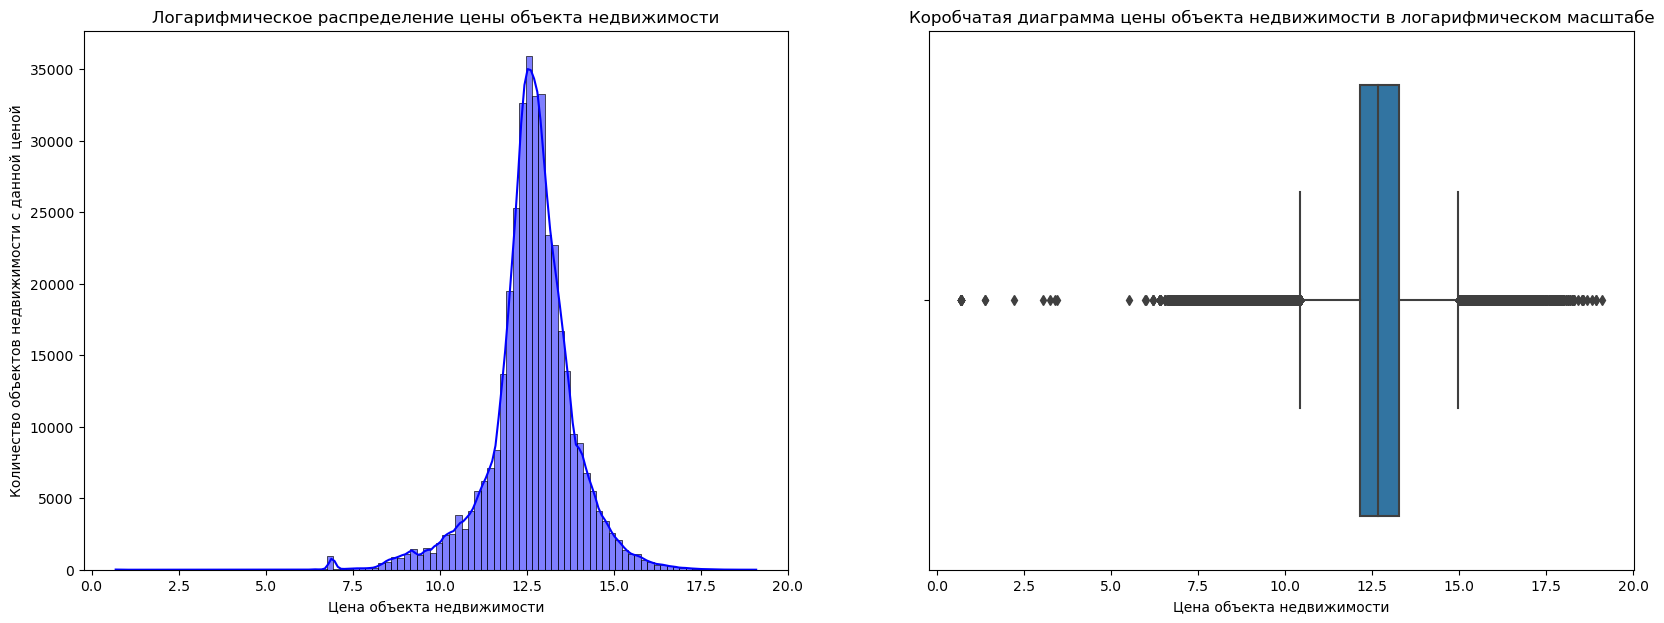

In [35]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 7))
histplot = sns.histplot(data = data, x = 'target_log', ax = ax[0], bins = 100, color = 'blue', kde = True)
histplot.set_title('Логарифмическое распределение цены объекта недвижимости')
histplot.set_xlabel('Цена объекта недвижимости')
histplot.set_ylabel('Количество объектов недвижимости с данной ценой')

boxplot = sns.boxplot(data = data, x = 'target_log', ax = ax[1], orient='h')
boxplot.set_title('Коробчатая диаграмма цены объекта недвижимости в логарифмическом масштабе');
boxplot.set_xlabel('Цена объекта недвижимости');

Получившийся результат не вполне похож на нормальное распределение, но на всякий случай перепроверяем это на тесте Д’Агостино при уровне значимости 𝛼=0.05.

In [36]:
# Выдвигаем нулевую и альтернативную гипотезы
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем нулевую гипотезу)'

alpha = 0.05
from scipy.stats import normaltest

# проверяем колонку 'target_log' на тесте Д’Агостино (проверка на нормальное распределение)
_, p = normaltest(data.target_log, nan_policy = 'omit')
print('Значение p-value = %.3f' % p)

# Интерпретация 
if p > alpha/2:
    print(H0)
else:
    print(Ha)

Значение p-value = 0.000
Данные не распределены нормально (мы отвергаем нулевую гипотезу)


# Перемещение данных между столбцами, создание нового признака type_of_house

В данном датасете чрезвычайно 'грязные' данные. Прежде всего они перемешаны между столбцами, поэтому прежде всего приходится переместить значения в соответствующие столбцы. Паралелльно  из признака 'propertyType' извлекаем данные о типе дома и помещаем в новый признак 'type_of_house'. 

Для удобства работы переводим данные в нижний регистр и удаляем лишние пробелы

In [37]:
data['propertyType'] = data['propertyType'].str.lower()
data['propertyType'] = data['propertyType'].str.replace(' {2,}', ' ', regex=True)
data['propertyType'] = data['propertyType'].str.strip()

In [38]:
data['stories'] = data['stories'].str.lower()
data['stories'] = data['stories'].str.replace(' {2,}', ' ', regex=True)
data['stories'] = data['stories'].str.strip()

In [39]:
data['baths'] = data['baths'].str.lower()
data['baths'] = data['baths'].str.replace(' {2,}', ' ', regex=True)
data['baths'] = data['baths'].str.strip()

In [40]:
def propertyType_stroka(text_stroka):  # переименовываем в однотипнные разные версии написания типа дома
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        if text_stroka == 'single family home' or text_stroka == 'single family' or text_stroka == 'singlefamilyresidence':
            text_stroka = 'single-family home'
        elif text_stroka == 'multi-family' or text_stroka == 'multi family':
            text_stroka = 'multi-family home'
        elif 'cooperative' in text_stroka:
            text_stroka = re.sub('cooperative', 'condo', text_stroka)
        elif 'high-rise' in text_stroka:
            text_stroka = re.sub('high-rise', 'high rise', text_stroka)
        elif 'hi-rise' in text_stroka:
            text_stroka = re.sub('hi-rise', 'high rise', text_stroka)
        elif 'mid-century' in text_stroka:
            text_stroka = re.sub('mid-century','midcentury', text_stroka)
        elif 'mid century' in text_stroka:
            text_stroka = re.sub('mid century','midcentury', text_stroka)
        elif 'farm house' in text_stroka:
            text_stroka = re.sub('farm house','farmhouse', text_stroka)
        elif text_stroka == 'other style' or text_stroka == 'other':
            text_stroka = 'other style home'
       
    return text_stroka

data['propertyType'] = data['propertyType'].apply(propertyType_stroka)

In [41]:
data.loc[data['propertyType'].str.extract('(single-family home)', expand=False) == 'single-family home', 'type_of_house'] \
            = 'single-family home'
data.loc[data['propertyType'].str.extract('(condominium)', expand=False) == 'condominium', 'type_of_house'] = 'condo'
data.loc[data['propertyType'].str.extract('(condo)', expand=False) == 'condo', 'type_of_house'] = 'condo'
data.loc[data['propertyType'].str.extract('(coop)', expand=False) == 'coop', 'type_of_house'] = 'coop'
data.loc[data['propertyType'].str.extract('(co-op)', expand=False) == 'co-op', 'type_of_house'] = 'coop'
data.loc[data['propertyType'].str.extract('(multi-family home)', expand=False) == 'multi-family home', 'type_of_house'] \
            = 'multi-family home'
data.loc[data['propertyType'].str.extract('(apartment)', expand=False) == 'apartment', 'type_of_house'] \
            = 'apartment'
data.loc[data['propertyType'].str.extract('(detached)', expand=False) == 'detached', 'type_of_house'] \
            = 'single-family home'
data.loc[data['propertyType'].str.extract('(mid-rise)', expand=False) == 'mid-rise', 'type_of_house'] \
            = 'coop hr_mr'
data.loc[data['propertyType'].str.extract('(high rise)', expand=False) == 'high rise', 'type_of_house'] \
            = 'coop hr_mr'
data.loc[data['propertyType'].str.extract('(townhouse)', expand=False) == 'townhouse', 'type_of_house'] \
            = 'townhouse'
data.loc[data['propertyType'].str.extract('(townhome)', expand=False) == 'townhome', 'type_of_house'] \
            = 'townhome'
data.loc[data['propertyType'].str.extract('(duplex)', expand=False) == 'duplex', 'type_of_house'] \
            = 'duplex'
data.loc[data['propertyType'].str.extract('(fourplex)', expand=False) == 'fourplex', 'type_of_house'] \
            = 'fourplex'
data.loc[data['propertyType'].str.extract('(multiplex)', expand=False) == 'multiplex', 'type_of_house'] \
            = 'multiplex'
data.loc[data['propertyType'].str.extract('(mobile)', expand=False) == 'mobile', 'type_of_house'] \
            = 'mobile manufactured house'
data.loc[data['propertyType'].str.extract('(ranch)', expand=False) == 'ranch', 'type_of_house'] = 'ranch'
data.loc[data['propertyType'].str.extract('(farmhouse)', expand=False) == 'farmhouse', 'type_of_house'] = 'ranch'
data.loc[data['propertyType'].str.extract('(farm/ranch)', expand=False) == 'farm/ranch', 'type_of_house'] = 'ranch'
data.loc[data['propertyType'].str.extract('(farms/ranches)', expand=False) == 'farms/ranches', 'type_of_house'] = 'ranch'
data.loc[data['propertyType'].str.extract('(farms/ranches)', expand=False) == 'farms/ranches', 'type_of_house'] = 'ranch'
data.loc[data['propertyType'].str.extract('(custom)', expand=False) == 'custom', 'type_of_house'] = 'custom'
data.loc[data['propertyType'].str.extract('(cluster home)', expand=False) == 'cluster home', 'type_of_house'] \
            = 'multi-family home'

In [42]:
data['type_of_house'].value_counts()

single-family home           192559
condo                         43492
townhouse                     18574
multi-family home             12387
townhome                       8522
mobile manufactured house      3486
coop                           3306
ranch                          3269
coop hr_mr                     2046
apartment                       940
custom                          265
duplex                          168
fourplex                         60
multiplex                        48
Name: type_of_house, dtype: int64

In [43]:
# перемещаем сведения об этажности постройки в соответствующий столбец
data.loc[data['propertyType'].str.extract('(one story)', expand=False) == 'one story', 'stories'] = '1'
data.loc[data['propertyType'].str.extract('(1 story)', expand=False) == '1 story', 'stories'] = '1'
data.loc[data['propertyType'].str.extract('(two story)', expand=False) == 'two story', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(2 story)', expand=False) == '2 story', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(2-story)', expand=False) == '2-story', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(2.5 story)', expand=False) == '2.5 story', 'stories'] = '2.5'
data.loc[data['propertyType'].str.extract('(1 1/2 story)', expand=False) == '1 1/2 story', 'stories'] = '1,5'

data.loc[data['propertyType'].str.extract('(2 stories)', expand=False) == '2 stories', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(1-3 stories)', expand=False) == '1-3 stories', 'stories'] = '3'
data.loc[data['propertyType'].str.extract('(8\\+ stories)', expand=False) == '8+ stories', 'stories'] = '8.5'
data.loc[data['propertyType'].str.extract('(4-7 stories)', expand=False) == '4-7 stories', 'stories'] = '5'
data.loc[data['propertyType'].str.extract('(3\\+ stories)', expand=False) == '3+ stories', 'stories'] = '3.5'

data.loc[data['propertyType'].str.extract('(3\\+ levels)', expand=False) == '3+ levels', 'stories'] = '3.5'
data.loc[data['propertyType'].str.extract('(3 level)', expand=False) == '3 level', 'stories'] = '3'
data.loc[data['propertyType'].str.extract('(tri-level)', expand=False) == 'tri-level', 'stories'] = '3'
data.loc[data['propertyType'].str.extract('(bi-level)', expand=False) == 'bi-level', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(bilevel)', expand=False) == 'bilevel', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(single level)', expand=False) == 'single level', 'stories'] = '1'
data.loc[data['propertyType'].str.extract('(quad level)', expand=False) == 'quad level', 'stories'] = '4'
data.loc[data['propertyType'].str.extract('(5\+ levels)', expand=False) == '5+ levels', 'stories'] = '5.5'
data.loc[data['propertyType'].str.extract('(4 levels)', expand=False) == '4 levels', 'stories'] = '4'
data.loc[data['propertyType'].str.extract('(one level)', expand=False) == 'one level', 'stories'] = '1'
data.loc[data['propertyType'].str.extract('(one story)', expand=False) == 'one story', 'stories'] = '1'
data.loc[data['propertyType'].str.extract('(1 story)', expand=False) == '1 story', 'stories'] = '1'
data.loc[data['propertyType'].str.extract('(two story)', expand=False) == 'two story', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(2 story)', expand=False) == '2 story', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(2-story)', expand=False) == '2-story', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(2.5 story)', expand=False) == '2.5 story', 'stories'] = '2.5'
data.loc[data['propertyType'].str.extract('(1 1/2 story)', expand=False) == '1 1/2 story', 'stories'] = '1,5'

data.loc[data['propertyType'].str.extract('(2 stories)', expand=False) == '2 stories', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(1-3 stories)', expand=False) == '1-3 stories', 'stories'] = '3'
data.loc[data['propertyType'].str.extract('(8\\+ stories)', expand=False) == '8+ stories', 'stories'] = '8.5'
data.loc[data['propertyType'].str.extract('(4-7 stories)', expand=False) == '4-7 stories', 'stories'] = '5'
data.loc[data['propertyType'].str.extract('(3\\+ stories)', expand=False) == '3+ stories', 'stories'] = '3.5'

data.loc[data['propertyType'].str.extract('(3\\+ levels)', expand=False) == '3+ levels', 'stories'] = '3.5'
data.loc[data['propertyType'].str.extract('(3 level)', expand=False) == '3 level', 'stories'] = '3'
data.loc[data['propertyType'].str.extract('(tri-level)', expand=False) == 'tri-level', 'stories'] = '3'
data.loc[data['propertyType'].str.extract('(bi-level)', expand=False) == 'bi-level', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(bilevel)', expand=False) == 'bilevel', 'stories'] = '2'
data.loc[data['propertyType'].str.extract('(single level)', expand=False) == 'single level', 'stories'] = '1'
data.loc[data['propertyType'].str.extract('(quad level)', expand=False) == 'quad level', 'stories'] = '4'
data.loc[data['propertyType'].str.extract('(5\+ levels)', expand=False) == '5+ levels', 'stories'] = '5.5'
data.loc[data['propertyType'].str.extract('(4 levels)', expand=False) == '4 levels', 'stories'] = '4'
data.loc[data['propertyType'].str.extract('(one level)', expand=False) == 'one level', 'stories'] = '1'
data.loc[data['propertyType'].str.extract('(2 levels)', expand=False) == '2 levels', 'stories'] = '2'

In [44]:
# из признака beds перемещаем данные о площади жилья в соответствующий столбец 'sqft'
def out_beds_to_sqft(vec):
    zn_sqft = vec[0]
    zn_beds = vec[1]
        
    if pd.notna(zn_beds):
        zn_beds = str(zn_beds)
        if zn_beds.endswith(' sqft') and (zn_sqft == 0 or pd.isna(zn_sqft)):
            return zn_beds
        else:
            return zn_sqft
    else:
        return zn_sqft
data['sqft'] = data[['sqft', 'beds']].apply(out_beds_to_sqft, axis=1)

In [45]:
# из признака beds перемещаем данные baths в соответствующий столбец
def beds_to_baths_stroka(vec):
    zn_baths = vec[0]
    zn_beds = vec[1]
        
    if pd.notna(zn_beds):
        zn_beds = str(zn_beds)
        
        if zn_beds.find('Bath') > 0:
            simb = zn_beds.find('Bath')
            nn = simb - 1
            zn_beds = zn_beds[:nn]
            return zn_beds
        else:
            return zn_baths
    else:
        return zn_baths
data['baths'] = data[['baths', 'beds']].apply(beds_to_baths_stroka, axis=1)

# Признак Schools

Признак 'Schools' содержит разные данные, которые следует для дальнейшей работы выделить в самостоятельные признаки:

* rating - рейтинги ближайших школ
* Distance - расстояния до ближайших школ
* Grades - группы классов в данных школах
* name - наименования ближайших школ

In [46]:
for i in tqdm(range(len(data)), desc='Обработано'):
    ss = data.loc[i][8]
    if pd.notna(ss): 
        ss = ss[1:-1]
        f_simb = ss.find('{')    # формируем признак rating
        e_simb = ss.find(']')
        nazv = 'rating'
        f_simb = ss.find('[')
        zn = ss[f_simb +1 : e_simb]
        data.at[i, nazv] = zn
    
        ss = ss[e_simb + 3:]
        f_simb = ss.find('{')    # формируем признак Distance
        e_simb = ss.find(']')
        nazv = 'Distance'
        f_simb = ss.find('[')
        zn = ss[f_simb +1 : e_simb]
        data.at[i, nazv] = zn
        
        ss = ss[e_simb + 3:]
        f_simb = ss.find('{')    # формируем признак Grades
        e_simb = ss.find(']')
        nazv = 'Grades'
        f_simb = ss.find('[')
        zn = ss[f_simb +1 : e_simb]
        data.at[i, nazv] = zn
        
        ss = ss[e_simb + 3:]
        f_simb = ss.find('{')    # формируем признак name
        e_simb = ss.find(']')
        nazv = 'name'
        f_simb = ss.find('[')
        zn = ss[f_simb +1 : e_simb]
        data.at[i, nazv] = zn
               
    i = i + 1

Обработано: 100%|████████████████████████████████████████████████████████████| 377185/377185 [01:35<00:00, 3929.26it/s]


In [47]:
pd.set_option("display.max_column", None)

In [48]:
data.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,target_log,type_of_house,rating,Distance,Grades,name
0,Active,NaN,single-family home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,418000.0,12.943239,single-family home,"'4', '4', '7', 'NR', '4', '7', 'NR', 'NR'","'2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 ...","'3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', '...","'Southern Pines Elementary School', 'Southern ..."
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,310000.0,12.644331,single-family home,"'4/10', 'None/10', '4/10'","'1.65mi', '1.32mi', '1.01mi'","'9-12', '3-8', 'PK-8'","'East Valley High School&Extension', 'Eastvall..."
2,for sale,NaN,single-family home,2005 Westridge Rd,2 baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0,14.878496,single-family home,"'8/10', '4/10', '8/10'","'1.19mi', '2.06mi', '2.63mi'","'6-8', 'K-5', '9-12'","'Paul Revere Middle School', 'Brentwood Scienc..."


В принципе можно попытаться выделить из этих новых признаков полезную информацию. Можно попытаться реализовать следующую идею: близость школ с высоким рейтингом косвенно может говорить о более безопасном районе проживания (соответственно, более зажиточном), жильё в котором должно стоить дороже. Однако за время выполнения проекта не успел реализовать этот алгоритм. Поэтому удаляю эти четыре вновь созданных признака.

In [49]:
# удаляем ненужные столбцы
data.drop(['rating', 'Distance', 'Grades', 'name'], inplace = True, axis = 1)

# Признак homeFacts

Признак 'homeFacts' сеодержит разыне данные, которые следует для дальнейшей работы выделить и разместить в шести новых признаках:
    
* Year_built - год постройки
* Remodeled year - год реконструкции
* Heating - отопление
* Cooling - охлаждение
* lotsize - размер земельного участка
* Price/sqft - соотношение цены и площади жилья

In [50]:
for i in tqdm(range(len(data)), desc='Обработано'):
    ss = data.loc[i][5]
    if pd.notna(ss): 
        # print('i= ', i, 'ss = ', ss)
        ss = ss[1:-1]
        f_simb = ss.find('{')    # формируем признак Year built
        e_simb = ss.find('}')
        sl = ss[f_simb: e_simb + 1]
        slovar = ast.literal_eval(sl)
        nazv = slovar['factLabel']
        zn = slovar['factValue']
        data.at[i, nazv] = zn
        
        ss = ss[e_simb + 3:]
        f_simb = ss.find('{')    # формируем признак Remodeled year
        e_simb = ss.find('}')
        sl = ss[f_simb: e_simb + 1]
        slovar = ast.literal_eval(sl)
        nazv = slovar['factLabel']
        zn = slovar['factValue']
        data.at[i, nazv] = zn
        
        ss = ss[e_simb + 3:]
        f_simb = ss.find('{')    # формируем признак Heating
        e_simb = ss.find('}')
        sl = ss[f_simb: e_simb + 1]
        slovar = ast.literal_eval(sl)
        nazv = slovar['factLabel']
        zn = slovar['factValue']
        data.at[i, nazv] = zn
        
        ss = ss[e_simb + 3:]
        f_simb = ss.find('{')    # формируем признак Cooling
        e_simb = ss.find('}')
        sl = ss[f_simb: e_simb + 1]
        slovar = ast.literal_eval(sl)
        nazv = slovar['factLabel']
        zn = slovar['factValue']
        data.at[i, nazv] = zn
        
        ss = ss[e_simb + 3:]
        f_simb = ss.find('{')    # формируем признак Parking
        e_simb = ss.find('}')
        sl = ss[f_simb: e_simb + 1]
        slovar = ast.literal_eval(sl)
        nazv = slovar['factLabel']
        zn = slovar['factValue']
        data.at[i, nazv] = zn
        
        ss = ss[e_simb + 3:]
        f_simb = ss.find('{')    # формируем признак lotsize
        e_simb = ss.find('}')
        sl = ss[f_simb: e_simb + 1]
        slovar = ast.literal_eval(sl)
        nazv = slovar['factLabel']
        zn = slovar['factValue']
        data.at[i, nazv] = zn
        
        ss = ss[e_simb + 3:]
        f_simb = ss.find('{')    # формируем признак Price/sqft
        e_simb = ss.find('}')
        sl = ss[f_simb: e_simb + 1]
        slovar = ast.literal_eval(sl)
        nazv = slovar['factLabel']
        zn = slovar['factValue']
        data.at[i, nazv] = zn
        
    i = i + 1

Обработано: 100%|████████████████████████████████████████████████████████████| 377185/377185 [03:34<00:00, 1755.53it/s]


Далее рассматриваем получившиеся новые признаки и оцениваем возможность их дальнейшего использования. 

# признак Year built

In [51]:
# проверим количество пропусков
data['Year built'].isna().sum()

3613

In [52]:
data.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,target_log,type_of_house,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,Active,NaN,single-family home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,418000.0,12.943239,single-family home,2019,,"Central A/C, Heat Pump",,,NaN,$144
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,310000.0,12.644331,single-family home,2019,,,,,5828 sqft,$159/sqft
2,for sale,NaN,single-family home,2005 Westridge Rd,2 baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0,14.878496,single-family home,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft


Помимо самих пропусков в данных имеются либо пустые строки, либо записи 'No Data'. Заменяем их на пропуски

In [53]:
# заполняем пропусками пустые значения и 'No Data'
data['Year built'] = data['Year built'].apply(clearing_)

In [54]:
# вычисляем медиану и заполняем ею отсутствующие значения, переводим их в числовой формат
median_yb = int(data['Year built'].median())
data['Year built']= data['Year built'].fillna(str(median_yb))
data['Year built'] = data['Year built'].astype(np.int64)

#### удаление выбросов

In [55]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5) # нижний перцентиль
    upper_bound = quartile_3 + (iqr * 1.5) # верхний перцентиль
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(data, 'Year built')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print ('lower_bound =', lower_bound)
print ('upper_bound =', upper_bound)


Число выбросов по методу Тьюки: 3725
Результирующее число записей: 373460
lower_bound = 1900.0
upper_bound = 2068.0


In [56]:
# считаем их выбросами, удаляем такие данные ( < 1900 и > 2068)
data.drop(outliers.index, inplace=True)

In [57]:
# поскольку данные непонятно какой свежести, вынуждены считать их собранных только что
# удаляем как недостоверные строки с датой постройки больше текущего года 
current_year = datetime.now().year;
incorrect_data = data[data['Year built'] > current_year]
data.drop(incorrect_data.index, inplace=True)

In [58]:
# Формируем новый признак  age_of_house - возраст дома
data['age_of_house'] = current_year - data['Year built']

In [59]:
# оцениваем количество уникальных значенмй в признаке
data['age_of_house'].nunique()

123

In [60]:
data.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,target_log,type_of_house,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,age_of_house
0,Active,NaN,single-family home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,418000.0,12.943239,single-family home,2019,,"Central A/C, Heat Pump",,,NaN,$144,4
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,310000.0,12.644331,single-family home,2019,,,,,5828 sqft,$159/sqft,4
2,for sale,NaN,single-family home,2005 Westridge Rd,2 baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0,14.878496,single-family home,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,62


# Remodeled year

Оцениваем количество пропусков в данных

In [61]:
data['Remodeled year'].isna().sum()

26262

In [62]:
data['Remodeled year'] = data['Remodeled year'].apply(clearing_)

In [63]:
data['Remodeled year'].isna().sum()

223627

Поскольку число пустых значений превышает 50%, исключаем этот признак из дальнейшего анализа (восстановить картину данных не представляется возможным)

# Признак Heating

Оцениваем количество пропусков в данных

In [64]:
data['Heating'].isna().sum()

3533

In [65]:
data['Heating'] = data['Heating'].apply(clearing_)

In [66]:
data['Heating'].isna().sum()

117193

Число пустых значений превышает 30%, исключаем этот признак из дальнейшего анализа (восстановить картину данных не представляется возможным)

# Признак Cooling

Оцениваем количество пропусков в данных

In [67]:
data['Cooling'].isna().sum()

3533

In [68]:
data['Cooling'] = data['Cooling'].apply(clearing_)

In [69]:
data['Cooling'].isna().sum()

132877

Число пустых значений превышает 30%, исключаем этот признак из дальнейшего анализа (восстановить картину данных не представляется возможным)

# Признак Parking

Оцениваем количество пропусков в данных

In [70]:
data['Parking'] = data['Parking'].apply(clearing_)

In [71]:
data['Parking'].isna().sum()

187059

Поскольку число пустых значений превышает 50%, исключаем этот признак из дальнейшего анализа (восстановить картину данных не представляется возможным)

# Признак lotsize

Оцениваем количество пропусков в данных

In [72]:
data['lotsize'] = data['lotsize'].apply(clearing_)
data['lotsize'].isna().sum()

66260

In [73]:
data['lotsize'].head(10)

0              NaN
1        5828 sqft
2       8,626 sqft
3       8,220 sqft
4      10,019 sqft
5         680 sqft
6    4,996 Sq. Ft.
7    8,750 Sq. Ft.
8           124582
9       2,056 sqft
Name: lotsize, dtype: object

При анализе данных в этом признаке обнаружилось, что в нем смешаны на мой взгляд площади участка и площади жилья. Например, присутствует значения площади участка примерно 9 кв.м, что представляется малореальным. Поскольку не нашел способа отделить одни данные от других, решил этот признак исключить из дальнейшего анализа.

# Признак Price/sqft

Интересный признак, с помощью которого можно попытаться восстановить отсутствующие данные в признаке sqft. Однако поскольку на курсе требовали не трогать целевой признак при анализе EDA, воспользоваться им не решился.

# Признак propertyType и новый признак type_of_house

Фактически нужгую информацию из этого признака мы выделили ранее. Здесь еще содержится масса информации, например, тип архитектуры жилья, но это представлено в столь малом количестве относительно общего набора данных, что решил такой информацией пренебречь, поскольку общую картину воссоздать более-менее достоверно не получится. 

In [74]:
data['type_of_house'].isna().sum()

87680

Надо будет удалить пропуски в признаке type_of_house, поскольку восстановить тип дома не получается, но сделаем это позже, при обработке признака baths.

# Признак status

In [75]:
data['status'] = data['status'].str.lower()
data['status'] = data['status'].str.replace(' {2,}', ' ', regex=True)
data['status'] = data['status'].str.strip()

In [76]:
data['status'].nunique()

150

In [77]:
# посмотрим одно из значений признака
data[data['status'] == 'condo for rent']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,target_log,type_of_house,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,age_of_house
50361,condo for rent,NaN,condo,465 Brickell Ave APT 401,3,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...","1,977 sqft",33131,3,FL,NaN,NaN,Yes,NaN,5000.0,8.517393,condo,1985,2008,Forced air,Central,1 space,None,$3,38
81559,condo for rent,NaN,condo,1200 Brickell Bay Dr PENTHOUSE 4214,2,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...","1,245 sqft",33131,3,FL,NaN,NaN,Yes,NaN,5500.0,8.612685,condo,1985,2005,Forced air,Central,1 space,None,$4,38
232399,condo for rent,NaN,condo,1000 1st Ave UNIT 1702,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Seattle,"[{'rating': ['2/10', '7/10', '7/10'], 'data': ...",NaN,98104,,WA,NaN,NaN,NaN,NaN,3995.0,8.293049,condo,1985,None,Forced air,Central,2 spaces,None,$3,38
247254,condo for rent,NaN,condo,325 S Biscayne Blvd APT 2926,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",NaN,33131,,FL,NaN,NaN,NaN,NaN,2850.0,7.955425,condo,1985,None,Forced air,Central,1 space,None,$2,38
265029,condo for rent,NaN,condo,10107 Sandy Hollow Ln APT 307,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Bonita Springs,"[{'rating': ['3/10', '7/10', '7/10'], 'data': ...",NaN,34135,2 bd,FL,NaN,NaN,NaN,NaN,1295.0,7.167038,condo,1985,NaN,Stove,Contact manager,2 spaces,NaN,$1,38
285109,condo for rent,NaN,condo,4300 N Lamont St APT 268,bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Las Vegas,"[{'rating': ['3/10', '2/10', '2/10'], 'data': ...",Total interior livable area: 864 sqft,89115,2 bd,NV,2.0,NaN,NaN,NaN,700.0,6.552508,condo,1985,1983,Forced air,Central,Carport,NaN,$1,38
340750,condo for rent,NaN,condo,1701 Washington St APT 201,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Hollywood,"[{'rating': ['3/10', '4/10', '4/10'], 'data': ...",NaN,33020,1 bd,FL,NaN,NaN,NaN,NaN,1200.0,7.090910,condo,1985,NaN,Forced air,Central,1 space,NaN,$1,38


Поскольку статусов продажи чересчур много, объединяем все продажи, сопряженные с какими-то обременениями в статус 'for reference'

In [78]:
def status_stroka(text_stroka):
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        
        if text_stroka == 'pre-foreclosure / auction':
            text_stroka = 'pre-foreclosure'
            
        elif text_stroka == 'foreclosed' or text_stroka == 'contingent foreclosure':
            text_stroka = 'foreclosure'
            
        elif text_stroka == 'active - auction' or text_stroka == 'auction - active' \
                            or text_stroka == '/ auction':
                            text_stroka = 'auction'
                
        elif text_stroka == 'new construction' or \
            text_stroka == 'new' or \
            text_stroka == 'price change' or \
            text_stroka == 'back on market':
            text_stroka = 'for sale'
        
        elif text_stroka == 'a active' or \
            text_stroka == 're activated' or \
            text_stroka == 'reactivated':
            text_stroka = 'active'
            
        elif text_stroka.find('sold') >= 0 or text_stroka == 'closed' \
            or text_stroka == 'contract':
            text_stroka = 'sold'
        
        elif text_stroka == 'condo for rent' or text_stroka == 'apartment for rent'or text_stroka == 'for rent':
            text_stroka = 'for rent'
            
        else:
            text_stroka = 'for reference'
                           
    return text_stroka

data['status'] = data['status'].apply(status_stroka)

In [79]:
# Оцениваем получившиеся статусы жилья
data['status'].value_counts()

for reference      322780
for sale             6787
pre-foreclosure      1543
auction               954
foreclosure           440
for rent              408
active                376
sold                  303
Name: status, dtype: int64

In [80]:
# выделяем самый популярный статус и заполняем им пропущенные значения
popular_status = data['status'].value_counts().index[0]
popular_status

'for reference'

In [81]:
data['status']= data['status'].fillna(popular_status)

In [82]:
data['status'].value_counts()

for reference      362647
for sale             6787
pre-foreclosure      1543
auction               954
foreclosure           440
for rent              408
active                376
sold                  303
Name: status, dtype: int64

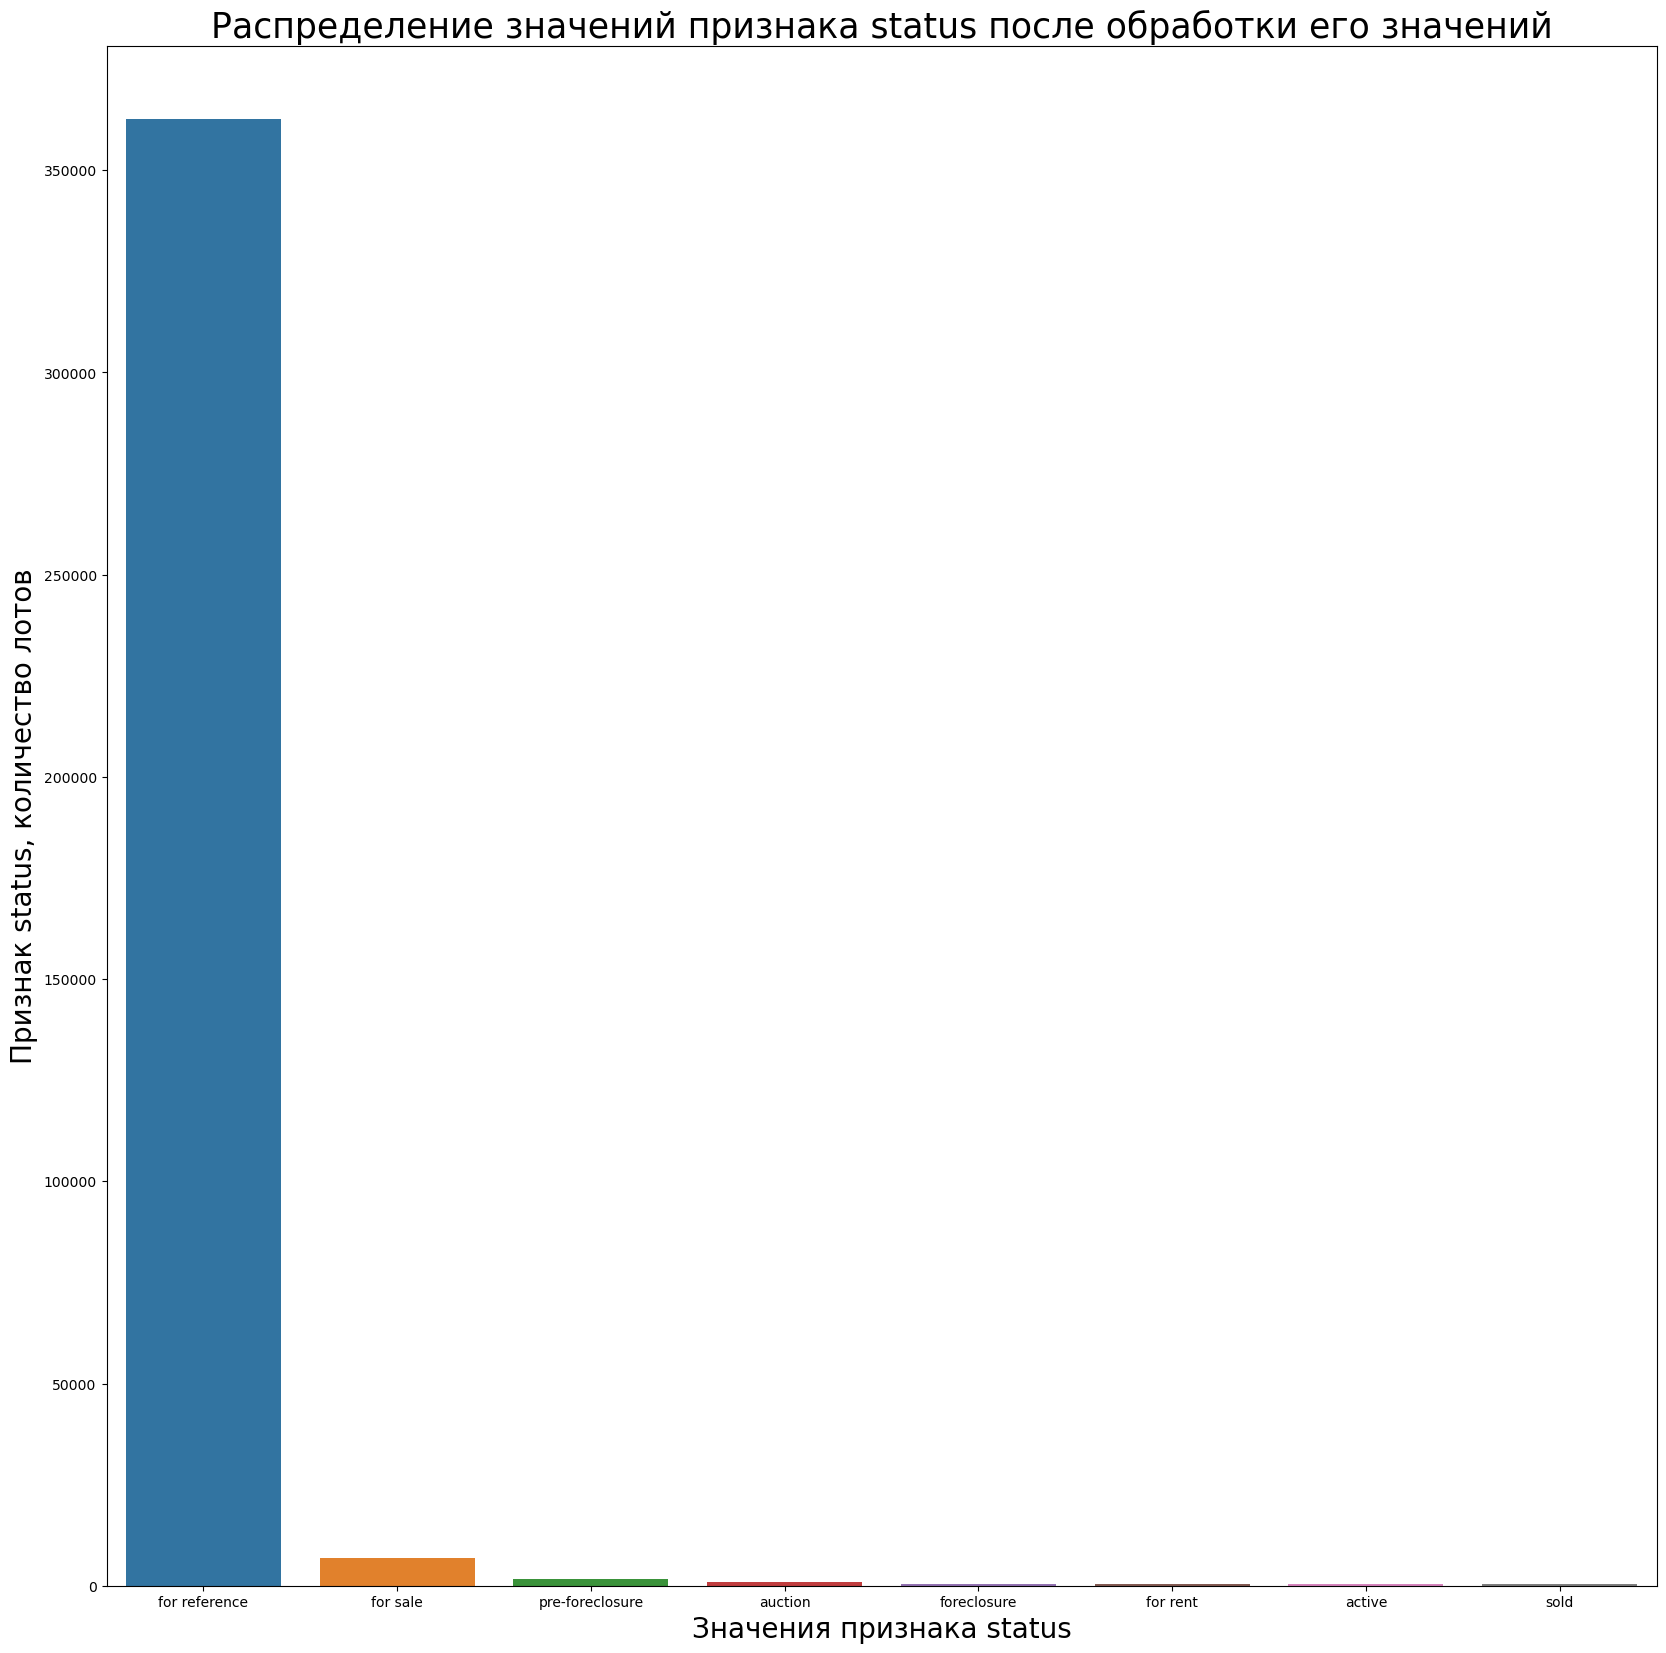

In [83]:
# Строим график по признаку status
plt.figure(figsize=(20,20))
plt.title('Распределение значений признака status после обработки его значений', fontsize=25)
sns.countplot(x='status', data=data)
plt.xlabel('Значения признака status', fontsize=20)
plt.ylabel('Признак status, количество лотов', fontsize=20)
plt.show()

# Признак baths

In [84]:
def baths_stroka(text_stroka): # обрабатывае данные для перевода строковых значений в числовой формат
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        if text_stroka.endswith(' baths'):
            text_stroka = text_stroka[:-6]
        elif text_stroka.endswith(' ba'):
            text_stroka = text_stroka[:-3]
        elif text_stroka.endswith('+'):
            text_stroka = text_stroka[:-1]  
        elif '~' in text_stroka or \
            '-' in text_stroka or \
            '—' in text_stroka or \
            'sq. ft.' in text_stroka:
            return np.nan  
        elif text_stroka == 'semimod':
            text_stroka = re.sub('semimod','0.5', text_stroka)
        elif text_stroka == '--':
            text_stroka = re.sub('--','0', text_stroka)
                        
        elif (text_stroka.find('/') >= 0) or (text_stroka.find('-') >= 0):   #строки типа 2-1 / 2-1 / 1-1 / 1-1
            return np.nan
        elif (text_stroka.find('/') >= 0) or (text_stroka.find('-') >= 0):   #строки типа 2-1 / 2-1 / 1-1 / 1-1
            return np.nan
            
        if text_stroka.startswith('bathrooms: '):
            text_stroka = text_stroka[11:]
            
        if text_stroka.find(',') > 0:
            text_stroka = text_stroka.replace(',','.')
            
    return text_stroka

data['baths'] = data['baths'].apply(baths_stroka) 

In [85]:
data['baths'].isna().sum()

106570

In [86]:
def baths_stroka_1(text_stroka): # поскольку не всегда с 1-го раза обрабатываются данные, повторяем часть кода 
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        if '--' in text_stroka:
            text_stroka = '0'
        elif '-' in text_stroka:
            text_stroka = '0'
        elif text_stroka == 'semimod':
            text_stroka = re.sub('semimod','0.5', text_stroka)
    return text_stroka

data['baths'] = data['baths'].apply(baths_stroka_1) 

In [87]:
data['baths'].isna().sum()

106570

In [88]:
# очищаем данные от пустых строк и значений 'No Data'
data['baths'] = data['baths'].apply(clearing_)

In [89]:
pd.set_option('display.max_rows', None)

In [90]:
data['baths'].value_counts()

2        84277
3        53616
4        21151
2.0      16392
2.5      12838
3.0      10748
1        10354
5         7548
1.0       5812
3.5       5477
4.0       4537
0         4300
6         3510
1.500     2199
1.5       2094
2.000     1788
1.750     1713
3.000     1683
7         1680
4.5       1547
5.0       1531
2.250     1440
1.000     1277
1.250     1205
2.750      965
8          928
2.500      894
6.0        728
3.500      653
5.5        518
9          434
7.0        358
4.000      290
10         263
750        232
5.000      230
8.0        215
6.5        191
11         153
12         113
9.0        101
1.75        94
7.5         62
13          57
10.0        53
2.1         53
16          46
14          41
2.75        35
8.5         31
18          30
11.0        30
15          24
0.00        23
12.0        21
7.500       19
0.0         18
2.25        17
1.1         17
13.0        16
24          15
20          14
10.5        13
3.1         12
3.25        11
17           9
3.75      

In [91]:
# переводим в числовой формат
data['baths'] = data['baths'].astype(float)

#### удаление выбросов

In [92]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5) # нижний перцентиль
    upper_bound = quartile_3 + (iqr * 1.5) # верхний перцентиль
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(data, 'baths')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print ('lower_bound =', lower_bound)
print ('upper_bound =', upper_bound)


Число выбросов по методу Тьюки: 23667
Результирующее число записей: 243221
lower_bound = 0.5
upper_bound = 4.5


Посмотрим получившуюся картину на графиках

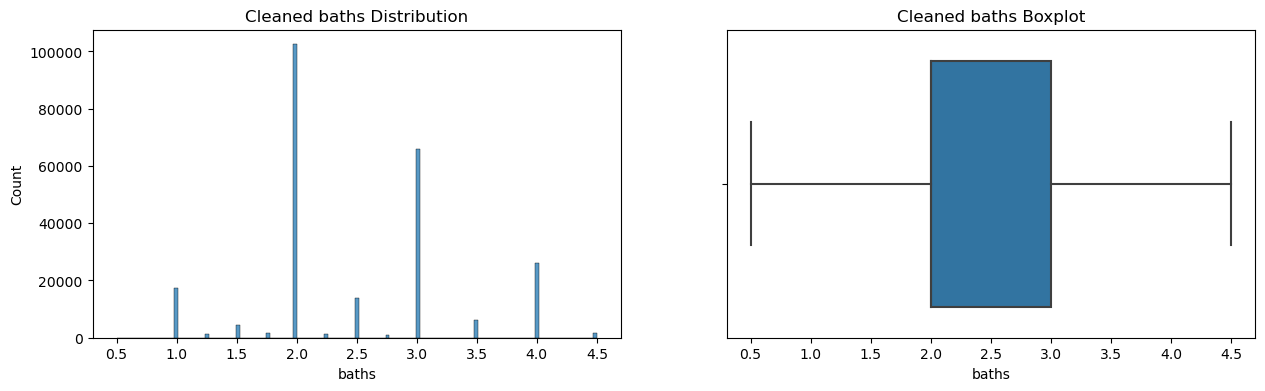

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='baths', ax=axes[0]);
histplot.set_title('Cleaned baths Distribution');
boxplot = sns.boxplot(data=cleaned, x='baths', ax=axes[1]);
boxplot.set_title('Cleaned baths Boxplot');

In [94]:
incorrect_data = data[(data['baths'] > upper_bound) | (data['baths'] < lower_bound)]
data.drop(incorrect_data.index, inplace=True)

In [95]:
data['baths'].value_counts()

2.00    102457
3.00     66047
4.00     25978
1.00     17443
2.50     13732
3.50      6130
1.50      4293
1.75      1807
4.50      1547
2.25      1457
1.25      1213
2.75      1000
2.10        53
1.10        17
3.10        12
3.25        11
3.75         8
4.10         3
0.50         2
2.20         2
4.25         2
0.75         2
3.20         2
3.30         1
1.80         1
2.80         1
Name: baths, dtype: int64

### обогащение данных по признаку baths

In [96]:
data['baths'].isna().sum()

106570

In [97]:
# Удаляем пропуски в признаке type_of_house. Этот признак понадобится нам при обогащении данных признака baths и других 
# признаков
data['type_of_house']= data['type_of_house'].fillna('necorrect')
incorrect_data = data[data['type_of_house'] == 'necorrect']
data.drop(incorrect_data.index, inplace=True)

Как видим, в столбце baths очень много пропусков. Заполнять их общим значением счел нецелеообразным. На мой взгляд, точнее было бы заполнить их медианой, исходя из значения признака type_of_house для конкретной записи. Для этого в ячейках ниже сначала формируем множество значений house_set признака type_of_house, потом это множество преобразуем в список t_h_list, а затем организуем цикл по этому списку, заполняя пропуски в baths медианой по выбранному из общего датасета фрагменту со значением признака type_of_house.

In [98]:
house_set = set(data['type_of_house'])
t_h_list = list(house_set)

In [99]:
t_h_list

['coop',
 'apartment',
 'ranch',
 'custom',
 'multi-family home',
 'mobile manufactured house',
 'fourplex',
 'townhouse',
 'townhome',
 'coop hr_mr',
 'condo',
 'duplex',
 'single-family home',
 'multiplex']

In [100]:
for i in range(len(t_h_list)):
    mask_out = data[data['type_of_house'] == t_h_list[i]]
    median_bt = mask_out['baths'].median()
    mask = data.type_of_house.str.contains(t_h_list[i], na = False, regex = True)
    data.loc[mask, 'baths'] = data.loc[mask, 'baths'].fillna(median_bt)

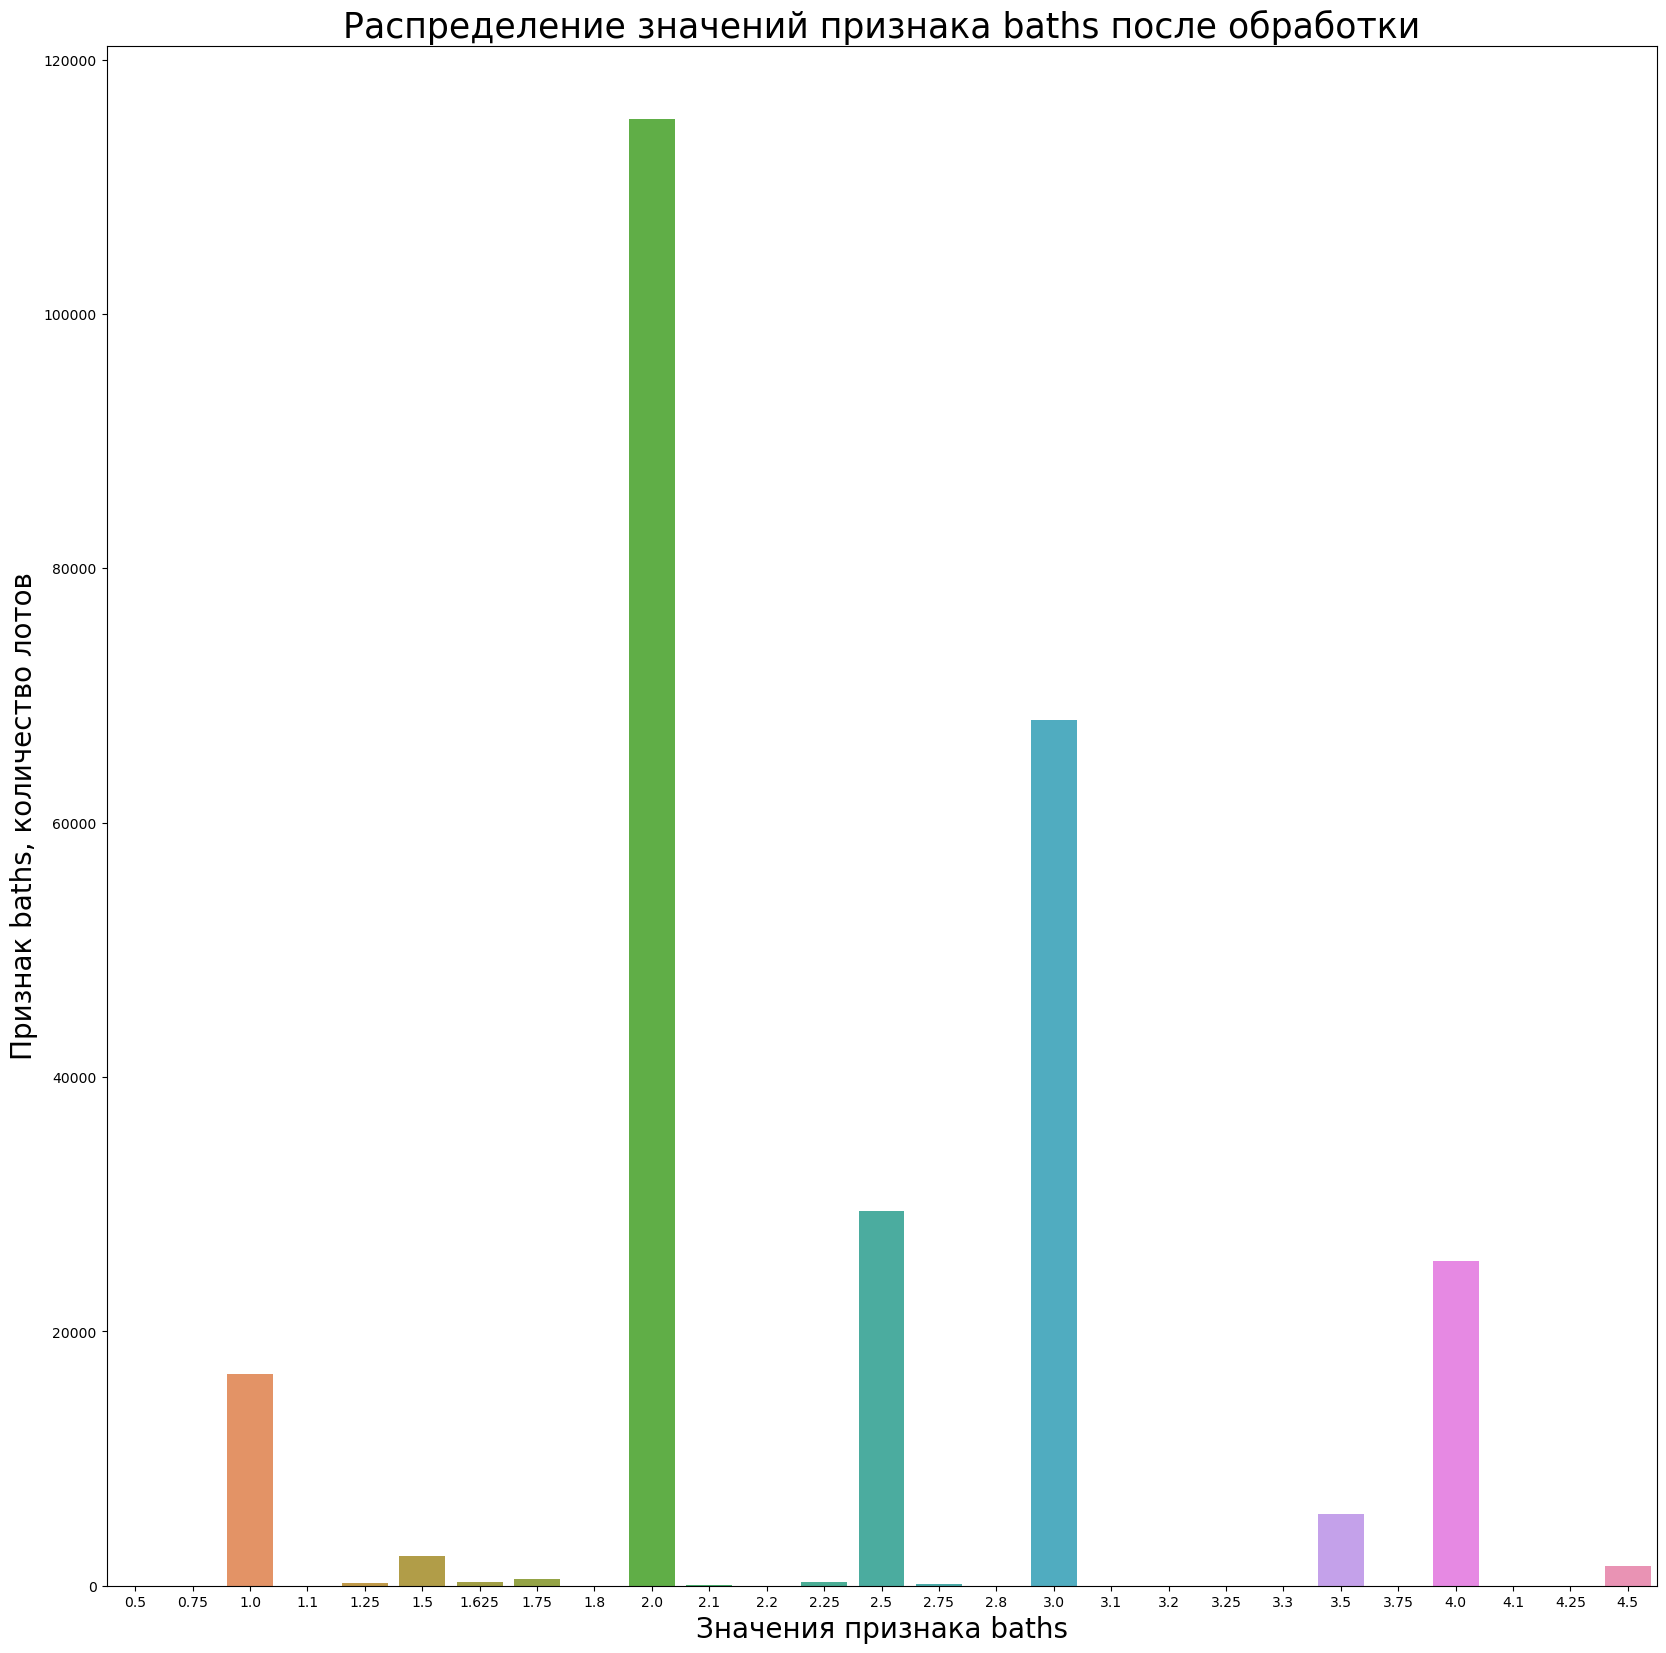

In [101]:
# Строим график по признаку baths
plt.figure(figsize=(20,20))
plt.title('Распределение значений признака baths после обработки', fontsize=25)
sns.countplot(x='baths', data=data)
plt.xlabel('Значения признака baths', fontsize=20)
plt.ylabel('Признак baths, количество лотов', fontsize=20)
plt.show()

## Признаки street, city и state

Эти признаки избыточны, поскольку для уточнения адреса нам достаточен признак zipcode. Не будем их использовать.

Но ради общего понимания валидности данных построим распределение числа лотов, выставленных на продажу, по штатам. 

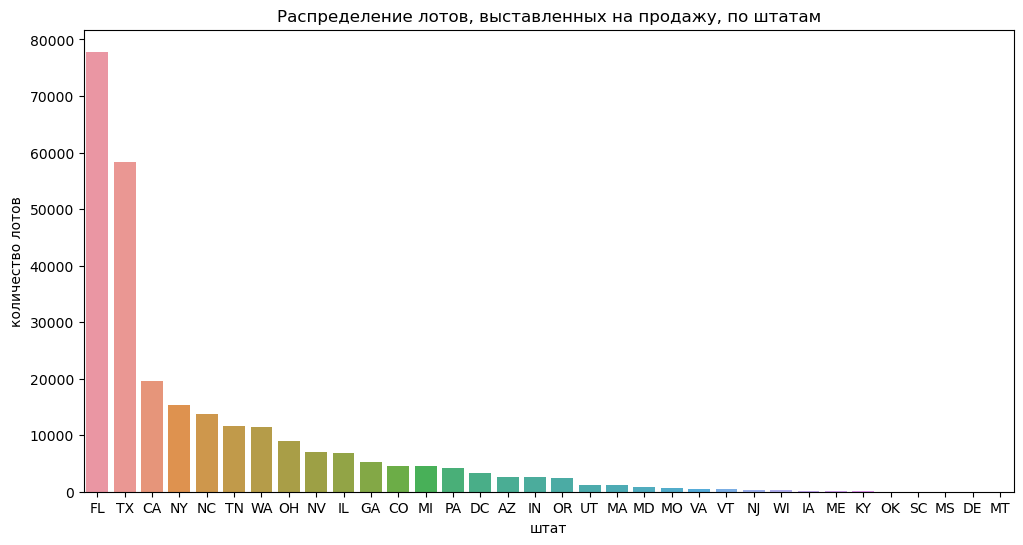

In [102]:
# Переведем признак state в категориальный тип
df_state = data.astype("category")
order=df_state.value_counts('state')

plt.rcParams['figure.figsize'] = (12,6)
fig, ax = plt.subplots()
bar = sns.barplot(data=data, x="state", y='target', estimator=len, order=order.index)
bar.set_title("Распределение лотов, выставленных на продажу, по штатам")
bar.set_xlabel("штат")
bar.set_ylabel("количество лотов")
plt.show()

Построенный график подтверждает обнаруженные в Интернете данные, что наибольшее количество квартир выставляются на продажу во Флориде и в Техасе, а следом за ними - в самых густонаселенных штатах - Нью_Йорке и Калифорнии. 

# Признаки private pool и PrivatePool

Признаки наличия бассейна разбросаны по 2-м столбцам датасета. Соединим их в один столбец и попытаемся оценить 

In [103]:
data['private pool'].value_counts()

Yes    3565
Name: private pool, dtype: int64

In [104]:
data['PrivatePool'].value_counts()

yes    23792
Yes     9098
Name: PrivatePool, dtype: int64

In [105]:
data['PrivatePool'] = data['PrivatePool'].str.lower()

In [106]:
data['PrivatePool'].value_counts()

yes    32890
Name: PrivatePool, dtype: int64

In [107]:
data.loc[(data['private pool'] == 'Yes'), 'PrivatePool'] = 'yes'

In [108]:
data['PrivatePool'].value_counts()

yes    36455
Name: PrivatePool, dtype: int64

In [109]:
data.loc[(data['private pool'] == 'Yes'), 'PrivatePool'] = 'yes'
data['PrivatePool'] =data['PrivatePool'].fillna('no')
data['PrivatePool'].value_counts()

no     229736
yes     36455
Name: PrivatePool, dtype: int64

Число лотов, имеющих бассейны, составляет менее 10% от общего числа, что крайне мало. На предварительных прогонах выяснилось, что этот признак самый малозначимый для метрик моделей. Поэтому решил не включать его для использования в окончательный вариант построения моделей.

# Признак sqft

Оценим исходное количество пропусков

In [110]:
data['sqft'].isna().sum()

4960

In [111]:
pd.set_option('display.max_rows', None)

In [112]:
data['sqft'].value_counts()

1,200 sqft                                   795
0                                            787
1,000 sqft                                   620
1,100 sqft                                   557
1,800 sqft                                   534
1,500 sqft                                   515
2,000 sqft                                   489
1,400 sqft                                   489
--                                           447
1,600 sqft                                   430
800 sqft                                     425
1,300 sqft                                   394
900 sqft                                     391
1,440 sqft                                   357
2,400 sqft                                   336
960 sqft                                     331
2,200 sqft                                   321
2,100 sqft                                   311
1,152 sqft                                   294
1,700 sqft                                   294
1,120 sqft          

In [113]:
# преобразуем строчные данные в вид, удобный для перевода в числовой формат
def sqft_stroka(text_stroka): 
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        
        if text_stroka.find(' sqft') > 0:
            text_stroka = text_stroka[:-5] # отсекаем суффикс ' sqft'
            
        if text_stroka.find('Total interior livable area: ') == 0: # убираем данный префикс
            text_stroka = text_stroka[29:]
            
        if text_stroka == '610-840':
            text_stroka =  '610'
        elif text_stroka == '--' or text_stroka == '0':   # нули и строки '--' заменяем пока пропусками
            return np.nan
        
        my_st = text_stroka.split(',')
        text_stroka = ''.join(my_st)
        
    return text_stroka

data['sqft'] = data['sqft'].apply(sqft_stroka)

In [114]:
# удаляем строки с отсутствующими значениями в столбце sqft
data.dropna(subset=['sqft'], inplace=True)

In [115]:
len(data)

259826

In [116]:
# переводим в числовой формат
data['sqft'] = data['sqft'].astype(float) 

In [117]:
# выводим минимальное значение площади в футах
data['sqft'].min()

1.0

In [118]:
# выводим максимальное значение площади в футах
data['sqft'].max()

795979430.0

In [119]:
# Оцениваем данные, площадь жилья которых слишком маленькая (меньше 15 кв.м = 160 кв.футам) или слишком большая (> 40000 футов)
incorrect_data = data[(data['sqft'] < 160) | (data['sqft'] >= 40000)]
len(incorrect_data)

981

In [120]:
# удаляем строки со слишком малой или слишком большой площадью
data.drop(incorrect_data.index, inplace=True)

In [121]:
data['sqft'] = data['sqft'].astype(np.float64)

In [122]:
data['sqft'].value_counts(bins = 25)

(120.40899999999999, 1743.6]    128182
(1743.6, 3327.2]                110655
(3327.2, 4910.8]                 17201
(4910.8, 6494.4]                  1871
(6494.4, 8078.0]                   364
(8078.0, 9661.6]                   168
(9661.6, 11245.2]                   89
(11245.2, 12828.8]                  57
(12828.8, 14412.4]                  43
(14412.4, 15996.0]                  25
(17579.6, 19163.2]                  24
(23914.0, 25497.6]                  22
(15996.0, 17579.6]                  19
(20746.8, 22330.4]                  17
(22330.4, 23914.0]                  14
(31832.0, 33415.6]                  14
(28664.8, 30248.4]                  13
(27081.2, 28664.8]                  12
(30248.4, 31832.0]                  12
(34999.2, 36582.8]                  11
(19163.2, 20746.8]                  11
(38166.4, 39750.0]                   9
(33415.6, 34999.2]                   5
(25497.6, 27081.2]                   5
(36582.8, 38166.4]                   2
Name: sqft, dtype: int64

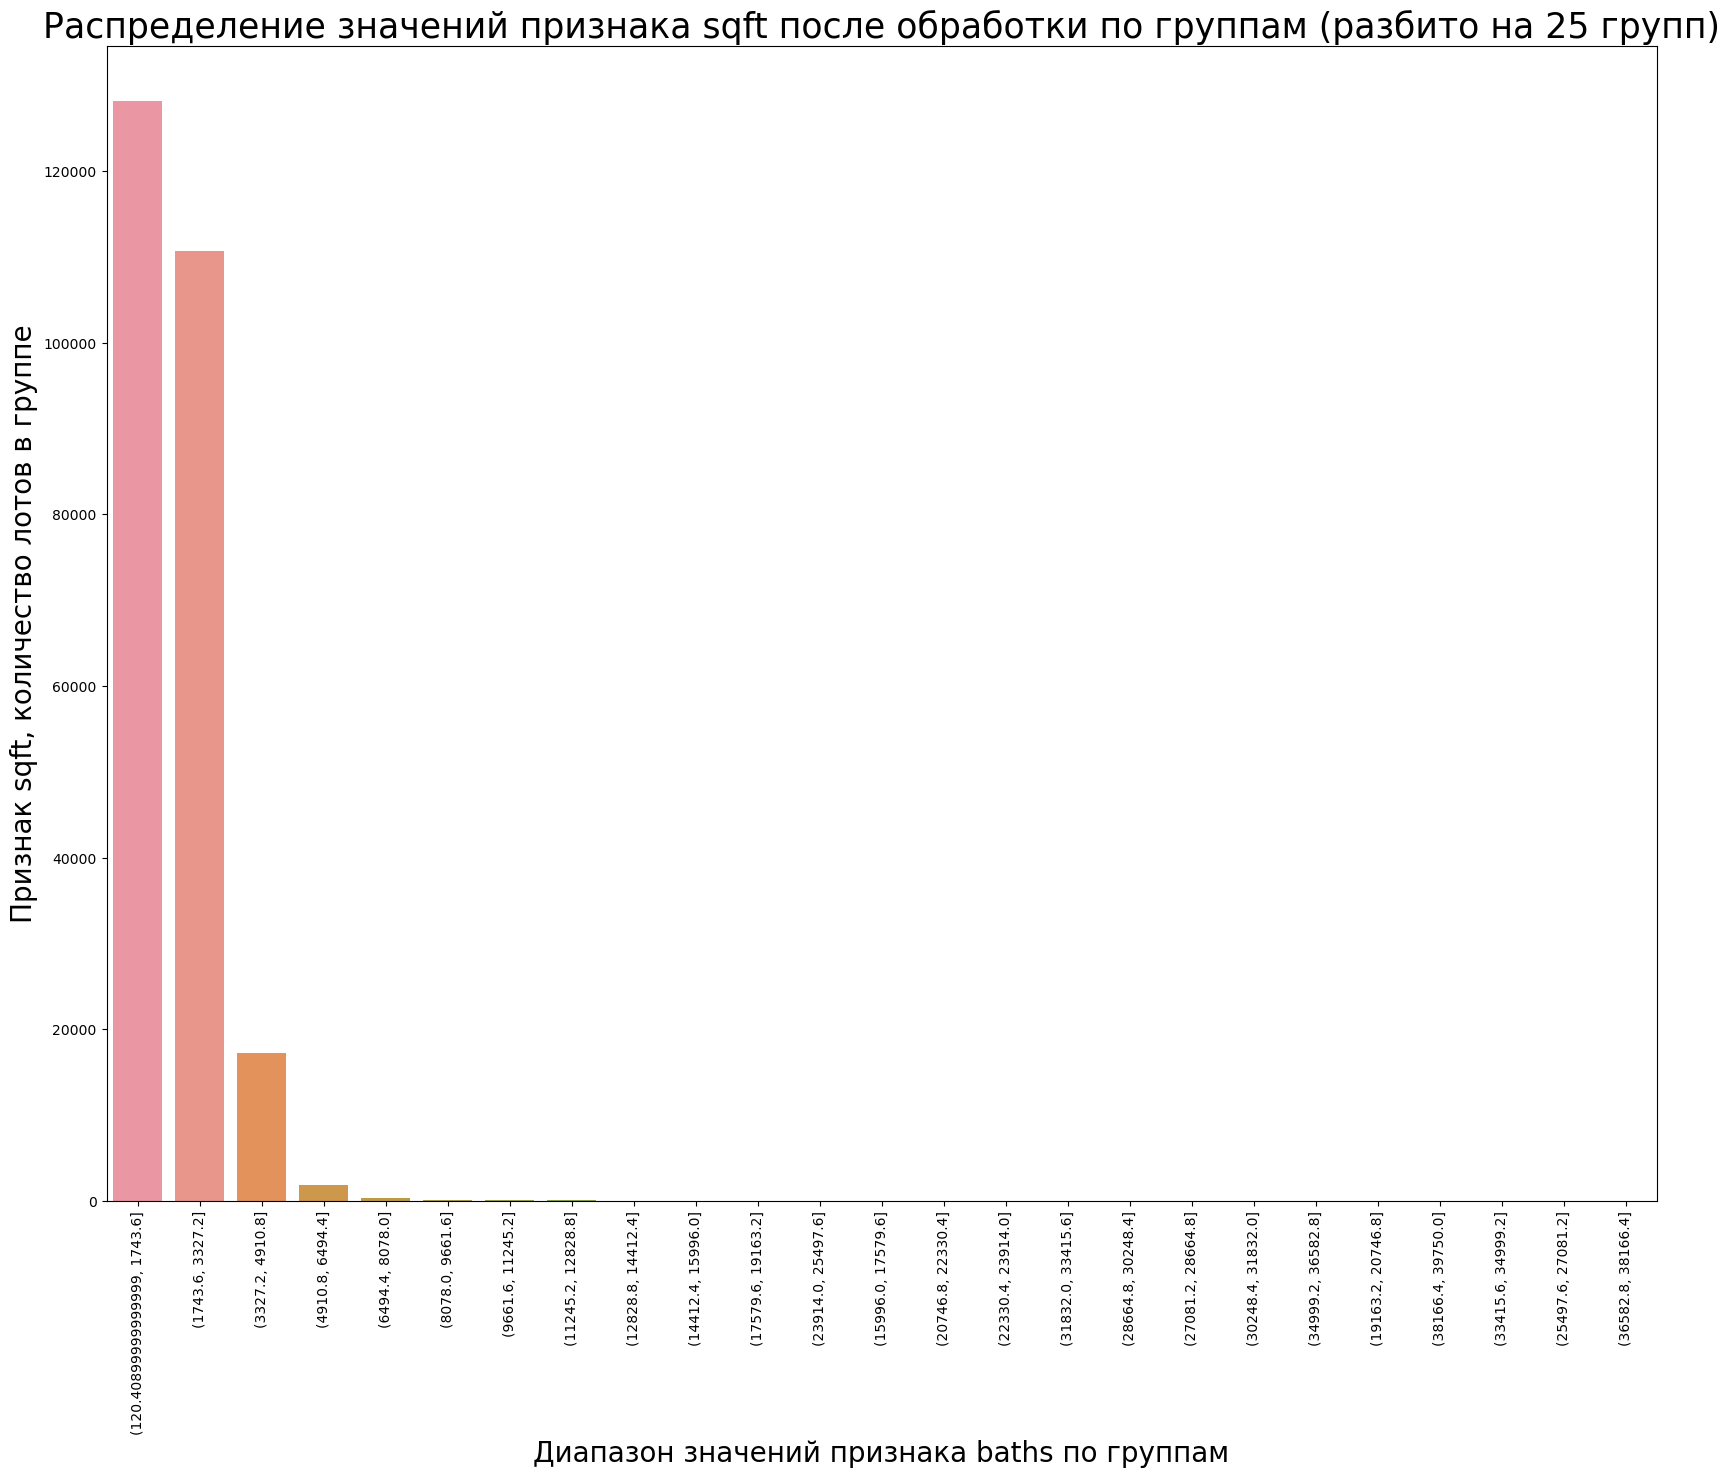

In [123]:
# Строим график по признаку sqft
plt.figure(figsize=(20,15))
plt.title('Распределение значений признака sqft после обработки по группам (разбито на 25 групп)', fontsize=25)
sns.barplot(x=data.sqft.value_counts(bins=25).index, y=data.sqft.value_counts(bins=25))
plt.xlabel('Диапазон значений признака baths по группам', fontsize=20)
plt.ylabel('Признак sqft, количество лотов в группе', fontsize=20)
plt.xticks(rotation = 'vertical')
plt.show()

# Признак stories

In [124]:
data['stories'] = data['stories'].str.lower()
data['stories'] = data['stories'].str.replace(' {2,}', ' ', regex=True)
data['stories'] = data['stories'].str.strip()

In [125]:
data['stories'].value_counts()

1.0                                           63618
2.0                                           46781
1                                             21613
2                                             13332
3.0                                            8859
0.0                                            6400
0                                              3751
9.0                                            2720
3                                              2543
2.00                                           2498
2 story                                        1912
4.0                                            1652
one                                            1551
1 story                                        1239
1.00                                           1161
3+                                              763
1.50                                            592
6.0                                             580
4                                               534
5.0         

In [126]:
# делаем для удобства обраотки единнообразным написание этажей в строке 
data['stories'] = data['stories'].str.replace('stories', 'story')

In [127]:
# переводим строковые значения в вид, пригодный для преобразования в числовой формат
def stories_stroka(text_stroka):
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        if 'two story or more' in text_stroka:
            text_stroka ='2.5'
                    
        elif 'or more' in text_stroka:
            text_stroka = re.sub(' or more','.5', text_stroka)
            
            if text_stroka.find(',') > 0:
                end = text_stroka.find(' ') - 1
            else:
                end = text_stroka.find(' ')
              
            otst =  1 if text_stroka.find(' ') < 0 else 2
            text_stroka = text_stroka[:end - otst]
            
            if text_stroka.isdigit() == False:
                if text_stroka == 'one':
                    text_stroka = '1'
                elif text_stroka == 'two':
                    text_stroka = '2'
                elif text_stroka == 'three':
                    text_stroka = '3'
            text_stroka = text_stroka + '.5'
                          
        elif ' story' in text_stroka:
            if '+' in text_stroka:
                text_stroka = re.sub('\\+','.5', text_stroka)
            number = re.search(r'(?:\d*\.*\d+|\w+) story', text_stroka, re.I)
            text_stroka = number[0][:number[0].find(' ')]
            if text_stroka.isdigit() == False:
                if text_stroka == 'one':
                    text_stroka = '1'
                elif text_stroka == 'two':
                    text_stroka = '2'
                elif text_stroka == 'three':
                    text_stroka = '3'
                    
        elif ' level' in text_stroka:
            if ' 1/2 levels' in text_stroka:
                text_stroka = re.sub(' 1/2 levels','.5', text_stroka)
            else:
                number = re.search(r'(?:\d*\.*\d+|\w+) level', text_stroka, re.I)
                text_stroka = number[0][:number[0].find(' ')]
                if text_stroka.isdigit() == False:
                    if text_stroka == 'one':
                        text_stroka = '1'
                    elif text_stroka == 'two':
                        text_stroka = '2'
                    elif text_stroka == 'three':
                        text_stroka = '3'
                            
# обработка остальных строковых значений
        elif text_stroka == 'one':
            text_stroka = '1'
        elif text_stroka == 'two' or text_stroka == 'bi-level':
            text_stroka = '2'
        elif text_stroka == 'one, two':
            text_stroka = '2'
        elif text_stroka == 'tri'or text_stroka == 'tri-level':
            text_stroka = '3'
        elif text_stroka == 'one and one half':
            text_stroka ='1.5'
        elif text_stroka == 'ground level':
            text_stroka ='1'
        elif text_stroka == 'none':
            text_stroka = np.nan
        elif '+' in text_stroka and text_stroka[-1] == '+' and text_stroka[:-1].isdigit():
            text_stroka = text_stroka[:-1] + '.5'
        elif text_stroka == 'raised ranch':
            text_stroka = '2'
        elif text_stroka == 'split foyer':
            text_stroka = '2'
        
    return text_stroka

data['stories'] = data['stories'].apply(stories_stroka)

In [128]:
# очистка от мусора(удаляем строковые значения, которые невозможно перевести в числа)
def clearing_str(text_stroka):
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        if is_number(text_stroka) == False:
            text_stroka = np.nan
        
    return text_stroka
data['stories'] = data['stories'].apply(clearing_str)

In [129]:
data['stories'].isna().sum()

69217

In [130]:
def stories_eq_null(text_stroka): # заполняем пропусками нулевые значения (в доме не может быть 0 этажей)
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        if text_stroka == '0.0'  or text_stroka == '0':
            text_stroka = np.nan
    return text_stroka

data['stories'] = data['stories'].apply(stories_eq_null)

In [131]:
data['stories'].isna().sum()

79368

In [132]:
# Смотрим медианные значения этажей по значениям в type_of_house
data.groupby('type_of_house')['stories'].median()

type_of_house
apartment                    2.0
condo                        2.0
coop                         6.0
coop hr_mr                   8.5
custom                       1.5
duplex                       2.0
fourplex                     2.0
mobile manufactured house    1.0
multi-family home            2.0
multiplex                    2.0
ranch                        1.0
single-family home           1.0
townhome                     2.0
townhouse                    2.0
Name: stories, dtype: float64

#### обогащение данных в признаке stories

In [133]:
# Обогащаем данные по той же логике, что была описана в признаке baths
for i in range(len(t_h_list)):
    mask_out = data[data['type_of_house'] == t_h_list[i]]
    median_st = mask_out['stories'].median()
    
    mask = data.type_of_house.str.contains(t_h_list[i], na = False, regex = True)
    data.loc[mask, 'stories'] = data.loc[mask, 'stories'].fillna(median_st)

In [134]:
# Проверяем, все ли пропуски обработаны
data['stories'].isna().sum()

0

In [135]:
# переводим количество этажей в числовой формат
data['stories'] = data['stories'].astype(np.float64)

In [136]:
# смотрим помещения с большой этажностью (более 70 этажей)
mm = data[data['stories'] > 70.0]

In [137]:
len(mm)

26

In [138]:
mm.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,target_log,type_of_house,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,age_of_house
14988,for reference,NaN,condo,125 Greenwich Ave #79D,4.0,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,New York,"[{'rating': ['9/10', '8/10', '3/10', '8/10', '...",1932.0,10014,3 Beds,NY,91.0,NaN,yes,2836355,6975000.0,15.757843,condo,2017,NaN,NaN,NaN,NaN,NaN,"$3,610/sqft",6
30622,for reference,NaN,condo,146 W 57th St #75C,2.0,"{'atAGlanceFacts': [{'factValue': '1986', 'fac...",NaN,New York,"[{'rating': ['9/10', '8/10', '3/10', '8/10', '...",1490.0,10019,2 Beds,NY,78.0,NaN,yes,4010574,4000000.0,15.201805,condo,1986,NaN,NaN,Central,1,0.43 acres,"$2,685/sqft",37
38609,for reference,NaN,condo,80 Columbus Cir #73C,4.0,"{'atAGlanceFacts': [{'factValue': '1955', 'fac...",yes,New York,"[{'rating': ['9/10', '8/10', '3/10', '8/10', '...",3165.0,10023,3 Beds,NY,80.0,NaN,yes,00114130,17500000.0,16.677711,condo,1955,NaN,NaN,NaN,Attached Garage,NaN,"$5,529/sqft",68


В датасете присутстуют данные с большой этажностью. 

Например, есть 26 записей с этажностью более 70, все они расположены в Нью-Йорке. Однако самое высокое здание в Нью_Йорке  - Всемирный торговый центр 1 (541 м). Нью-Йорк, США - имеет 104 этажа. Исходя из этого, записи с этажностью более 104 удаляем из датасета как недостоверные(2 строки). Также убираем строки, где количество этажей меньше 1(одна строка).

In [139]:
incorrect_data = data[(data['stories'] > 104) | (data['stories'] < 1)]
data.drop(incorrect_data.index, inplace=True)

In [140]:
data['stories'].value_counts()

1.00     136006
2.00      96547
3.00      12119
6.00       3490
9.00       3156
4.00       2273
1.50       1009
3.50        978
5.00        671
2.50        452
7.00        338
8.00        304
12.00       112
16.00        90
11.00        87
20.00        74
14.00        65
15.00        64
21.00        60
17.00        58
10.00        58
13.00        51
19.00        43
25.00        42
18.00        40
23.00        39
8.50         38
33.00        35
24.00        35
30.00        29
22.00        28
27.00        26
31.00        25
43.00        24
40.00        22
36.00        20
28.00        20
29.00        19
1.75         19
46.00        19
26.00        18
42.00        15
32.00        14
38.00        13
1.70         13
47.00        13
45.00        12
34.00        10
57.00        10
60.00        10
44.00         9
37.00         9
6.50          9
48.00         8
35.00         8
54.00         6
41.00         6
77.00         6
52.00         6
70.00         6
63.00         5
56.00         5
39.00   

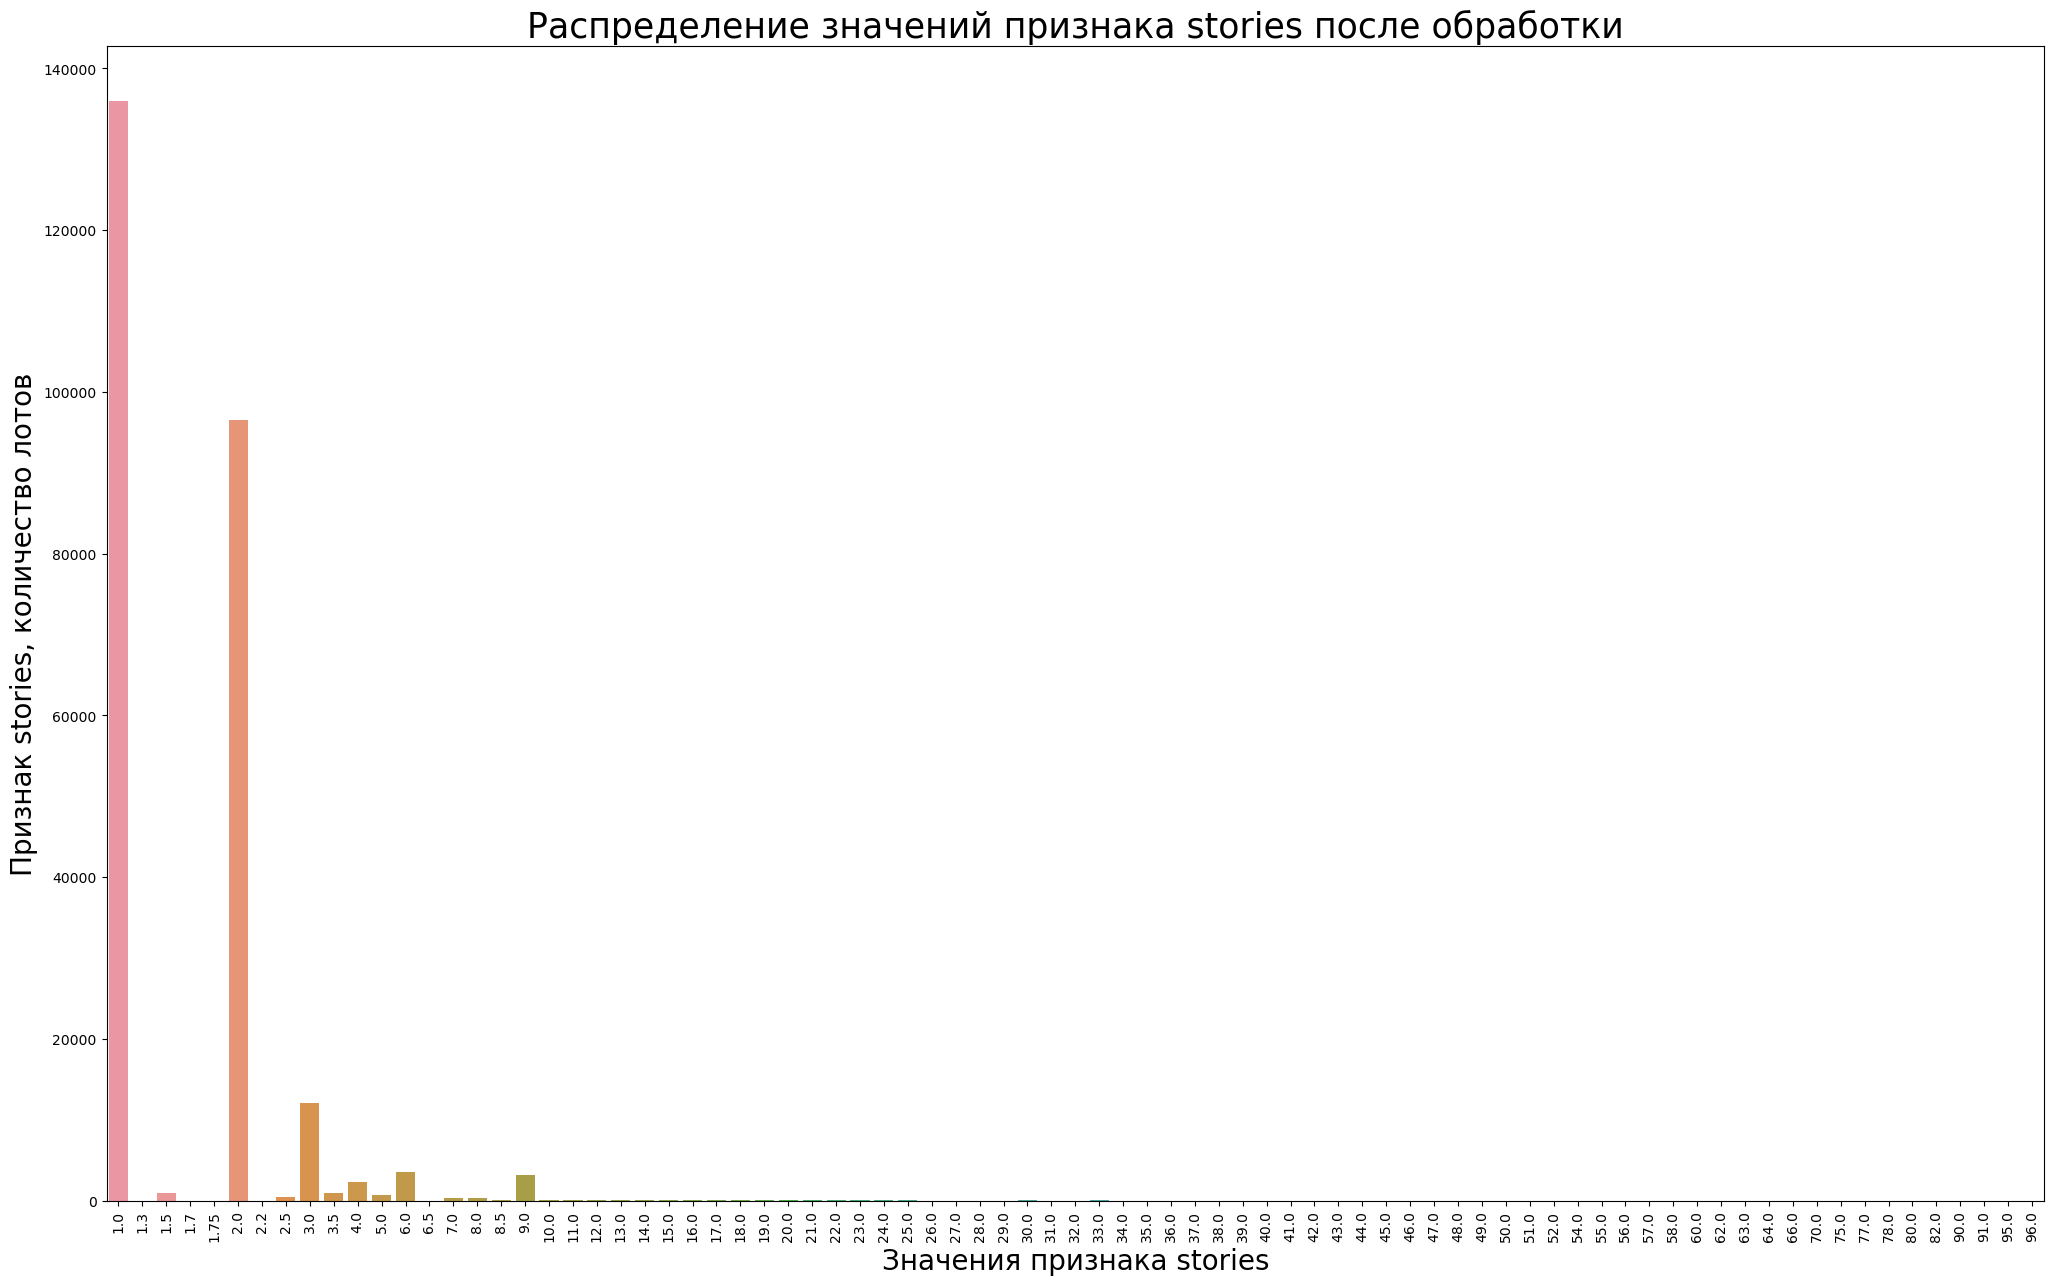

In [141]:
# Строим график по признаку stories
plt.figure(figsize=(25,15))
sns.countplot(x='stories', data=data)
plt.title('Распределение значений признака stories после обработки', fontsize=25)
plt.xlabel('Значения признака stories', fontsize=20)
plt.ylabel('Признак stories, количество лотов', fontsize=20)
plt.xticks(rotation = 'vertical')
plt.show()

# Признак beds

In [142]:
pd.set_option('display.max_rows', None)

In [143]:
# преобразуем строки, содержащие слово 'Bedroom', в вид, удобный для перевода в числовой формат
def bedroom_to_beds_stroka(text_stroka): 
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        if text_stroka.find('Bedroom') > 0:
            simb = text_stroka.find('Bedroom')
            nn = simb - 1
            text_stroka = text_stroka[:nn]  # обрезаем строку с начала до слова bedroom
            
            f_simb = text_stroka.rfind(',')
            if f_simb > 0:
                text_stroka = text_stroka[f_simb + 2:nn]
            else:
                text_stroka = text_stroka[:nn] # обрезаем строку по формату: последняя запятая + 1 символ - конец строки
                                
            if text_stroka.find(' ') > 0:
                end_simb = text_stroka.find(' ')
                text_stroka = text_stroka[:end_simb] # обрезаем строку по первому пробелу с начала строки
            
            if text_stroka == '#':
                text_stroka = '2'
                
    return text_stroka

data['beds'] = data['beds'].apply(bedroom_to_beds_stroka)

In [144]:
# # преобразуем остальные строчные данные в вид, удобный для перевода в числовой формат
def beds_stroka(text_stroka):
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        if text_stroka.endswith(' Beds'):
            text_stroka = text_stroka[:-5]
        elif text_stroka.endswith(' bd'):
            if text_stroka.endswith('--'):
                text_stroka = '0.5'
            else:
                text_stroka = text_stroka[:-3]
        elif text_stroka.endswith(' sqft') or text_stroka.endswith(' acres') or text_stroka.endswith(' acre'):
            text_stroka = np.nan

    return text_stroka

data['beds'] = data['beds'].apply(beds_stroka)

In [145]:
# очищаем столбей от ненужного мусора, заменяя пропусками
data['beds'] = data['beds'].apply(clearing_str)

In [146]:
# оцениваем количество получившихся пропусков в признаке
data['beds'].isna().sum()

23664

In [147]:
data['beds'] = data['beds'].astype(np.float64)

In [148]:
# # Обогащаем данные по той же логике, что была описана в признаке baths с той лишь разницей, что некоторых группах 
# type_of_house все значения заполнены пропусками, поэтому приходится назначать значение медианы вручную 
for i in range(len(t_h_list)):
    mask_out = data[data['type_of_house'] == t_h_list[i]]
    median_st = mask_out['stories'].median()
    
    mask = data.type_of_house.str.contains(t_h_list[i], na = False, regex = True)
    data.loc[mask, 'stories'] = data.loc[mask, 'stories'].fillna(median_st)
for i in range(len(t_h_list)):
    mask_out = data[data['type_of_house'] == t_h_list[i]]
    if t_h_list[i] == 'custom':
        median_bd = 3.0
    elif t_h_list[i] == 'duplex':
        median_bd = 2.0
    elif t_h_list[i] == 'fourplex':
        median_bd = 3.0
    elif t_h_list[i] == 'multiplex':
        median_bd = 4.0
    else:
        median_bd = mask_out['beds'].median()
    mask = data.type_of_house.str.contains(t_h_list[i], na = False, regex = True)
    data.loc[mask, 'beds'] = data.loc[mask, 'beds'].fillna(median_bd)
    
    i = i + 1

In [149]:
data['beds'].value_counts()

3.0     112072
4.0      63190
2.0      58634
5.0      13941
1.0       5824
6.0       2875
0.0        981
7.0        574
8.0        462
9.0        135
10.0        70
12.0        30
11.0        25
20.0         6
13.0         5
16.0         4
14.0         3
17.0         2
15.0         2
23.0         2
44.0         1
30.0         1
33.0         1
18.0         1
24.0         1
Name: beds, dtype: int64

#### обработка выбросов признака beds

In [150]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5) # нижний перцентиль
    upper_bound = quartile_3 + (iqr * 1.5) # верхний перцентиль
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(data, 'beds')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print ('lower_bound =', lower_bound)
print ('upper_bound =', upper_bound)


Число выбросов по методу Тьюки: 751
Результирующее число записей: 258091
lower_bound = -1.0
upper_bound = 7.0


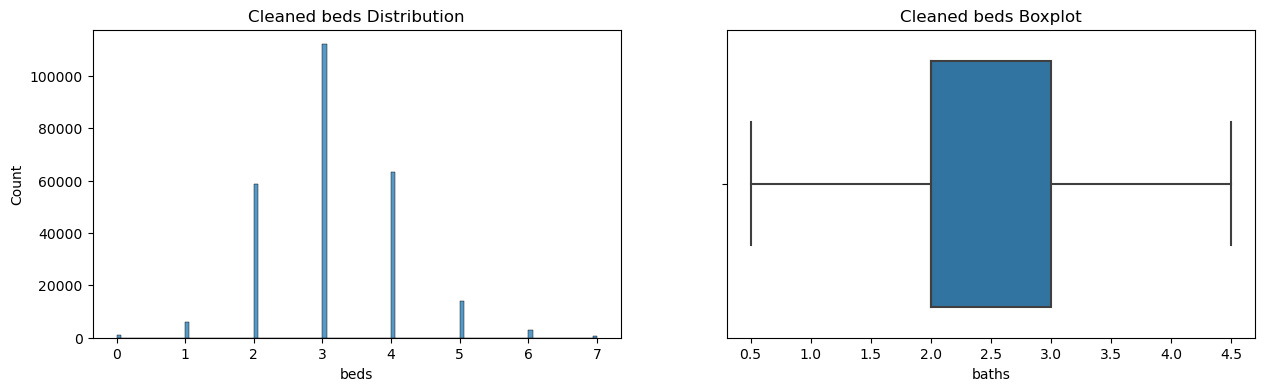

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='beds', ax=axes[0]);
histplot.set_title('Cleaned beds Distribution');
boxplot = sns.boxplot(data=cleaned, x='baths', ax=axes[1]);
boxplot.set_title('Cleaned beds Boxplot');

In [152]:
# Удаляем записи, в которых число спален > 7
data.drop(outliers.index, inplace=True)

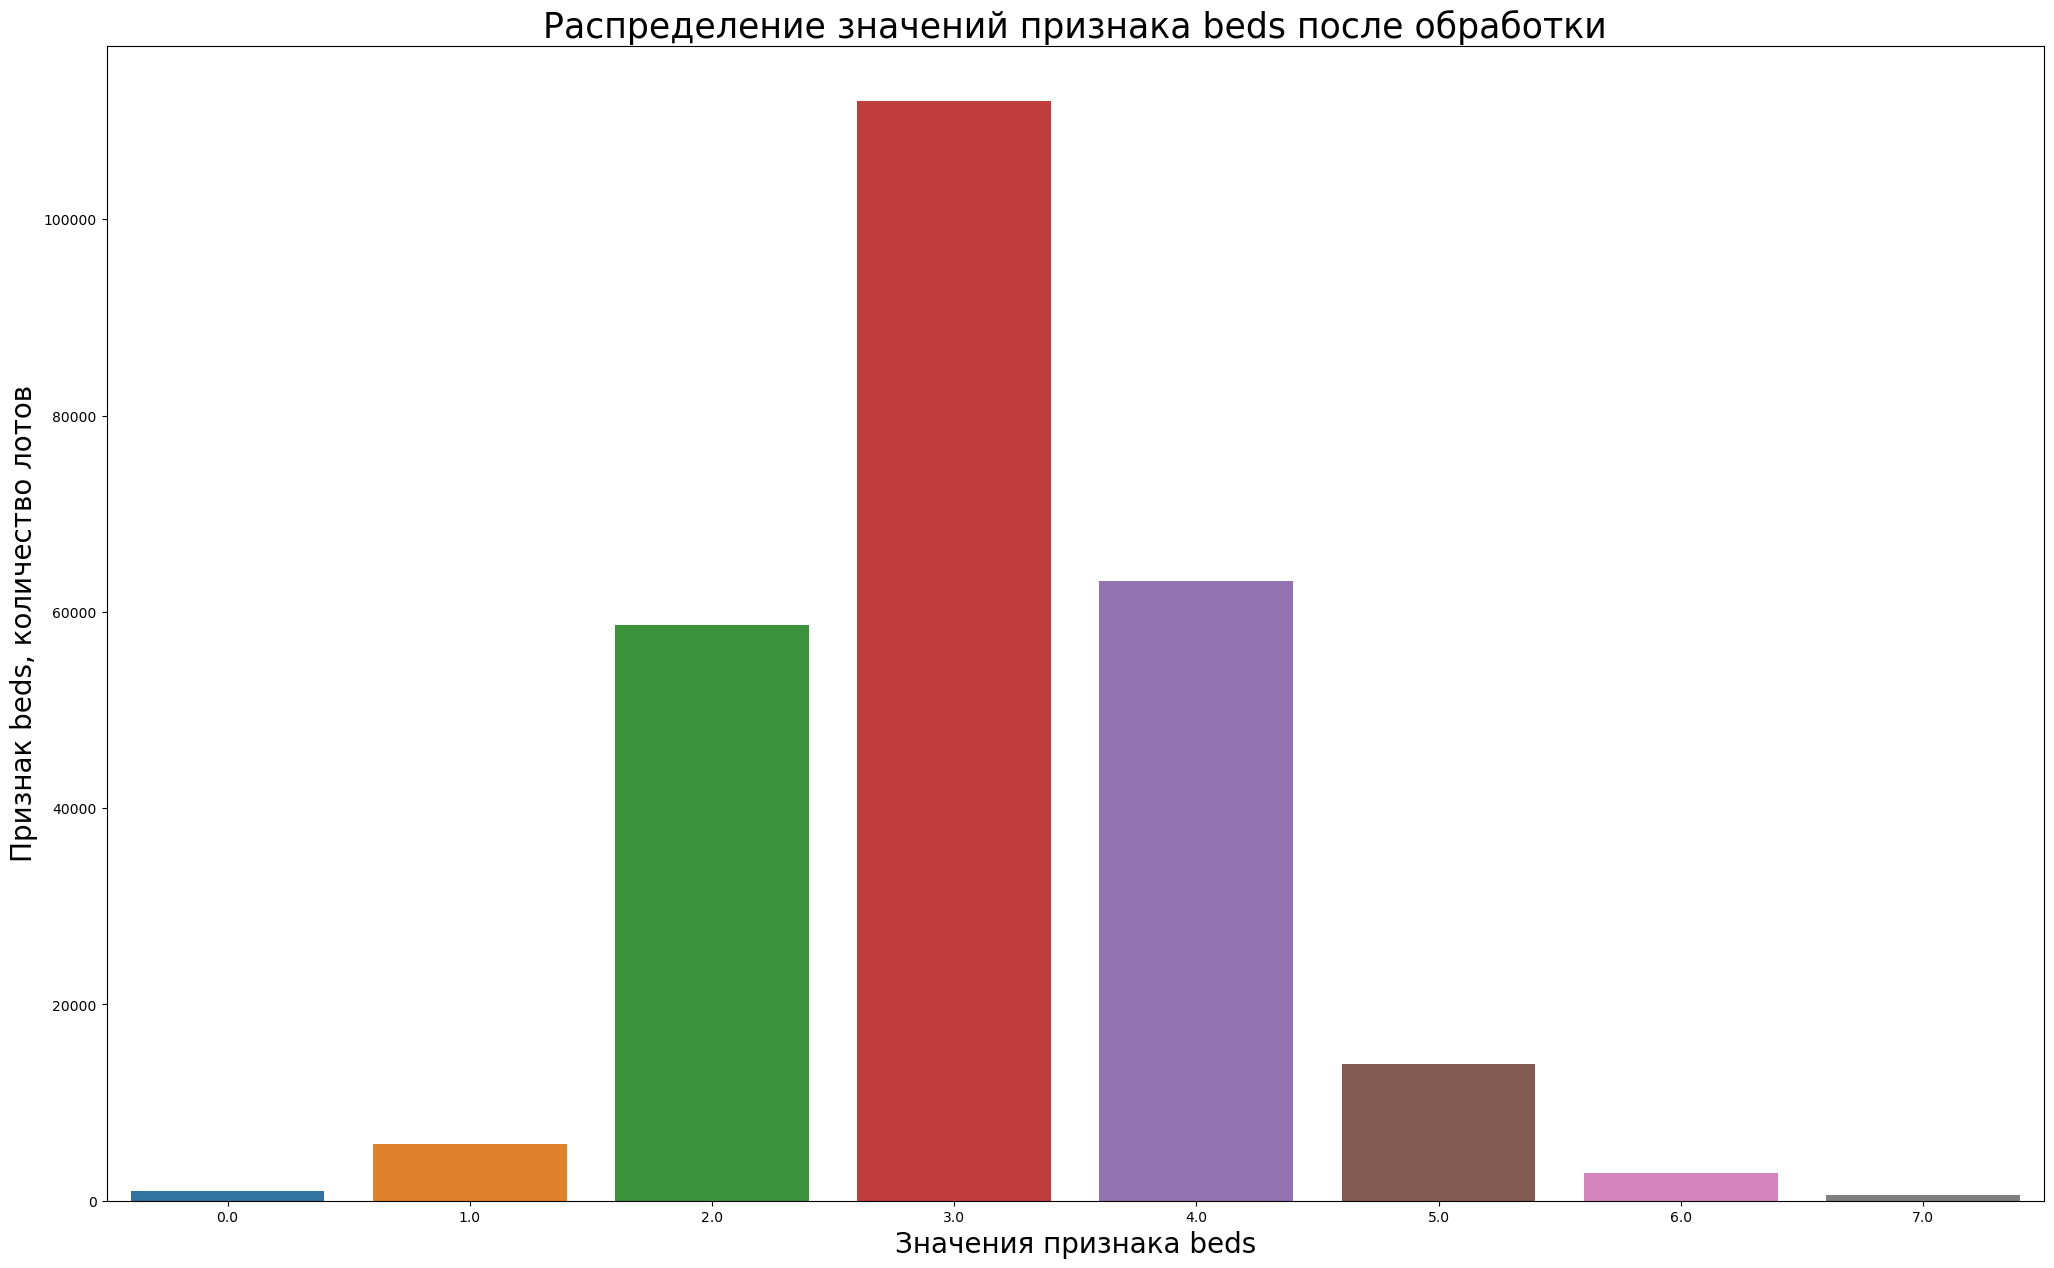

In [153]:
# Строим график по признаку beds
plt.figure(figsize=(25,15))
sns.countplot(x='beds', data=data)
plt.title('Распределение значений признака beds после обработки', fontsize=25)
plt.xlabel('Значения признака beds', fontsize=20)
plt.ylabel('Признак beds, количество лотов', fontsize=20)
plt.show()

# Признак fireplace

In [154]:
data['fireplace'].isna().sum()

178104

Поскольку число пустых ячеек значительно превышает количество заполненных, восстановить данные  с приемлемой достоверностью не представляется возможным. Исключаем признак из дальнейшего анализа.  

# Удаление дубликатов

In [155]:
mask = data.duplicated()
duplicates = data[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

data.drop_duplicates(inplace=True)
print(f'Результирующее число записей: {data.shape[0]}')

Число найденных дубликатов: 50
Результирующее число записей: 258041


### Удаление ненужных столбцов и дубликатов

In [156]:
# удаляем ненужные столбцы
data.drop(['propertyType', 'private pool', 'PrivatePool', 'street', 'homeFacts', 'city', 'schools', 'state', 'mls-id', \
           'MlsId', 'Year built','Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft', \
           'fireplace'], inplace = True, axis = 1)

### Удаление пропусков в целевом признаке

In [157]:
# оцениваем количество пропусков
data['target_log'].isna().sum()

1844

In [158]:
# удаляем строки с пропусками, поскольку они совершенно бесполезны для предсказания
data['target_log']= data['target_log'].fillna('necorrect')
incorrect_data = data[data['target_log'] == 'necorrect']
data.drop(incorrect_data.index, inplace=True)

### Подготовка к построению моделей (удаление оставшихся дубликатов, разделение данных на обучающую и валидационную выборки, нормализация данных)

In [159]:
data.head(3)

,status,baths,sqft,zipcode,beds,stories,target,target_log,type_of_house,age_of_house
0,for reference,3.5,2900.0,28387,4.0,1.0,418000.0,12.943239,single-family home,4
1,for reference,3.0,1947.0,99216,3.0,2.0,310000.0,12.644331,single-family home,4
2,for reference,2.0,3000.0,90049,3.0,1.0,2895000.0,14.878496,single-family home,62


In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256197 entries, 0 to 377184
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         256197 non-null  object 
 1   baths          256197 non-null  float64
 2   sqft           256197 non-null  float64
 3   zipcode        256197 non-null  object 
 4   beds           256197 non-null  float64
 5   stories        256197 non-null  float64
 6   target         256197 non-null  float64
 7   target_log     256197 non-null  object 
 8   type_of_house  256197 non-null  object 
 9   age_of_house   256197 non-null  int64  
dtypes: float64(5), int64(1), object(4)
memory usage: 21.5+ MB


Повторное удаление дубликатов: поскольку удалены признаки street, city и state, то образовались новые дубликаты (например, однотипные квартиры в многоэтажном доме). Удаляем их. 

In [161]:
# удаление дубликатов
mask = data.duplicated()
duplicates = data[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

data.drop_duplicates(inplace=True)
print(f'Результирующее число записей: {data.shape[0]}')

Число найденных дубликатов: 22484
Результирующее число записей: 233713


In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233713 entries, 0 to 377184
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         233713 non-null  object 
 1   baths          233713 non-null  float64
 2   sqft           233713 non-null  float64
 3   zipcode        233713 non-null  object 
 4   beds           233713 non-null  float64
 5   stories        233713 non-null  float64
 6   target         233713 non-null  float64
 7   target_log     233713 non-null  object 
 8   type_of_house  233713 non-null  object 
 9   age_of_house   233713 non-null  int64  
dtypes: float64(5), int64(1), object(4)
memory usage: 19.6+ MB


In [163]:
# записываем получившийся датасет в файл
data.to_csv('data/nedv_afterEDA.csv', index=False)

In [164]:
data_baseline = data.copy()

In [165]:
data.shape

(233713, 10)

In [166]:
X = data.drop(['target', 'target_log'], axis=1)
y = data['target']
y_log = data['target_log']

In [167]:
cols_to_code = ['status','zipcode', 'type_of_house']
encoder = ce.BinaryEncoder(cols=cols_to_code)
# data = encoder.fit_transform(data)
data = encoder.fit_transform(data.drop(['target', 'target_log'], axis=1))

In [168]:
data.shape

(233713, 25)

In [169]:
data.head(3)

,status_0,status_1,status_2,baths,sqft,zipcode_0,zipcode_1,zipcode_2,zipcode_3,zipcode_4,zipcode_5,zipcode_6,zipcode_7,zipcode_8,zipcode_9,zipcode_10,zipcode_11,zipcode_12,beds,stories,type_of_house_0,type_of_house_1,type_of_house_2,type_of_house_3,age_of_house
0,0,0,1,3.5,2900.0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0,1.0,0,0,0,1,4
1,0,0,1,3.0,1947.0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.0,2.0,0,0,0,1,4
2,0,0,1,2.0,3000.0,0,0,0,0,0,0,0,0,0,0,0,1,1,3.0,1.0,0,0,0,1,62


In [170]:
X = data

In [171]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

In [172]:
# Нормализуем обучающую и валидационную выборки с помощью MinMaxScaler из библиотеки sklearn
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [173]:
len(X_train)

156587

In [174]:
len(X_valid)

77126

# Построение моделей

#### Линейная регрессия

In [175]:
lreg = linear_model.LinearRegression()
lreg.fit(X_train_scaled, y_train_log)

y_train_pred = lreg.predict(X_train_scaled)
y_valid_pred = lreg.predict(X_valid_scaled)

print('RSMLE train score:', round(metrics.mean_squared_error(y_train_log, y_train_pred)**.5, 2))
print('RSMLE valid score:', round(metrics.mean_squared_error(y_valid_log, y_valid_pred)**.5, 2))

RSMLE train score: 0.8
RSMLE valid score: 0.78


#### Полиномиальная регрессия

In [176]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_valid_scaled_poly = poly.transform(X_valid_scaled)

In [177]:
#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_scaled_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_scaled_poly)
#Делаем предсказание для валидационной выборки
y_valid_predict_poly = lr_model_poly.predict(X_valid_scaled_poly)

print('RSMLE train score:', round(metrics.mean_squared_error(y_train_log, y_train_predict_poly)**.5, 2))
print('RSMLE valid score:', round(metrics.mean_squared_error(y_valid_log, y_valid_predict_poly)**.5, 2))

RSMLE train score: 0.73
RSMLE valid score: 20230157.99


Метрика уменьшились для тренировочной выборки, но очень сильно увеличилась для тестовой. Поэтому имеет смысл посмотреть модель полиномиальной регрессии второй степени с L2-регуляризацией

#### Полиномиальная регрессия с L2-регуляризацией

In [178]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=1.0)
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для валидационной выборки
y_valid_predict_poly = ridge_lr_poly.predict(X_valid_scaled_poly)

print('RSMLE train score:', round(metrics.mean_squared_error(y_train_log, y_train_predict_poly)**.5, 2))
print('RSMLE valid score:', round(metrics.mean_squared_error(y_valid_log, y_valid_predict_poly)**.5, 2))

RSMLE train score: 0.73
RSMLE valid score: 0.72


#### Дерево решений

Поиск оптимальных параметров глубины для дерева решений

In [179]:
def des_tree(depth):
 
    dtr = DecisionTreeRegressor(max_depth = depth, random_state = 42)
  
    dtr.fit(X_train_scaled, y_train_log)

    y_train_pred = dtr.predict(X_train_scaled)
    y_valid_pred = dtr.predict(X_valid_scaled)

    train_metric = round(metrics.mean_squared_error(y_train_log, y_train_pred)**.5, 3)
    valid_metric = round(metrics.mean_squared_error(y_valid_log, y_valid_pred)**.5, 3)
    
    return train_metric, valid_metric

train_val = {} # словарь для метрик обучающей выборки 
valid_val = {} # словарь для метрик валидационной выборки
for i in range(7, 15):
    train_val[i], valid_val[i] =  des_tree(i)

In [180]:
# преобразуем данные словарей в списки для построения графиков
key_train = list(train_val.keys())          
train_score = list(train_val.values())
key_valid = list(train_val.keys())
valid_score = list(valid_val.values())

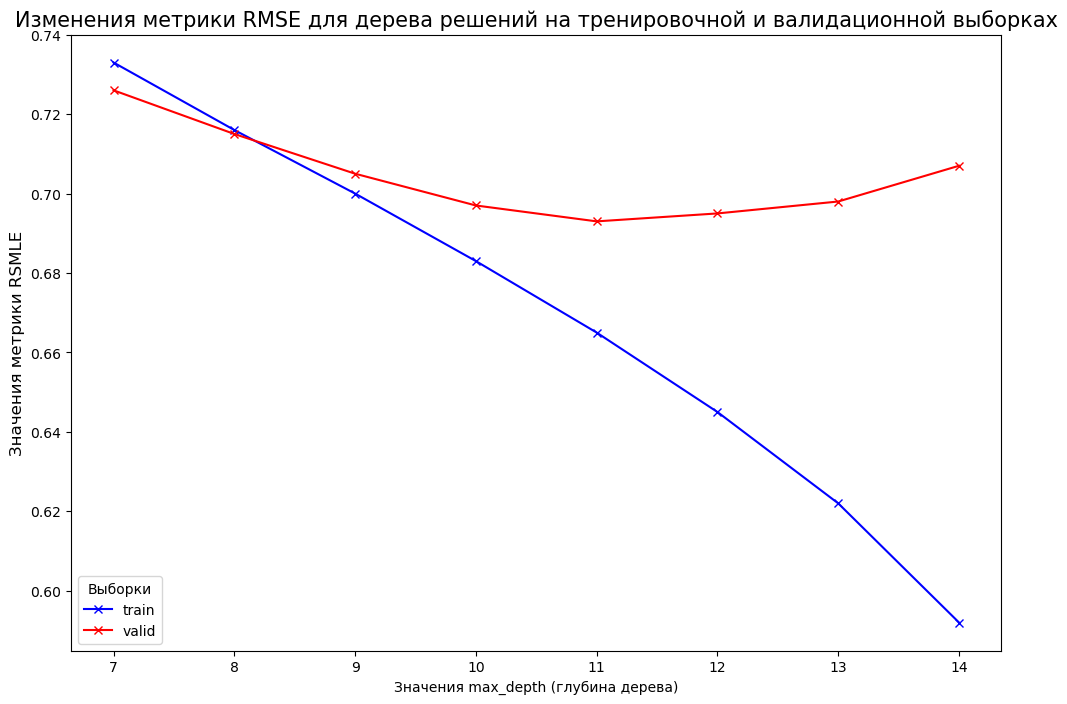

In [181]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(key_train, train_score, 'xb-')
plt.plot(key_valid, valid_score, 'xr-')
plt.title('Изменения метрики RMSE для дерева решений на тренировочной и валидационной выборках', fontsize=15)
plt.legend(title='Выборки', loc='lower left', labels=['train', 'valid'])
plt.xlabel("Значения max_depth (глубина дерева)", fontsize=10)
plt.ylabel("Значения метрики RSMLE", fontsize=12)
plt.show()

На графике видим, что после значения глубины, равного 11, метрика выборки valid начинает возрастать. Соответственно, эта глубина оптимальна и считаем результтат именно с этой глубиной

In [182]:
dtr = DecisionTreeRegressor(max_depth = 11, random_state = 42)
dtr.fit(X_train_scaled, y_train_log)

y_train_pred = dtr.predict(X_train_scaled)
y_valid_pred = dtr.predict(X_valid_scaled)

print('RSMLE train score:', round(metrics.mean_squared_error(y_train_log, y_train_pred)**.5, 2))
print('RSMLE valid score:', round(metrics.mean_squared_error(y_valid_log, y_valid_pred)**.5, 2))

RSMLE train score: 0.67
RSMLE valid score: 0.69


#### Случайный лес

In [183]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestRegressor(
    n_estimators = 200,
    max_depth = 11, 
    criterion = 'squared_error',
    min_samples_split = 20,
    random_state=42)

#Обучаем модель
%time rf.fit(X_train_scaled, y_train_log)

y_train_pred = rf.predict(X_train_scaled)
y_valid_pred = rf.predict(X_valid_scaled)

print('RSMLE train score:', round(metrics.mean_squared_error(y_train_log, y_train_pred)**.5, 2))
print('RSMLE valid score:', round(metrics.mean_squared_error(y_valid_log, y_valid_pred)**.5, 2))

CPU times: total: 1min 40s
Wall time: 1min 40s
RSMLE train score: 0.65
RSMLE valid score: 0.67


#### Градиентный бустинг

In [184]:
gboost = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100, 
    max_depth=6,
    min_samples_split=30,
    random_state=42)

#Обучаем модель
%time gboost.fit(X_train_scaled, y_train_log)

y_train_pred = gboost.predict(X_train_scaled)
y_valid_pred = gboost.predict(X_valid_scaled)

print('RSMLE train score:', round(metrics.mean_squared_error(y_train_log, y_train_pred)**.5, 2))
print('RSMLE valid score:', round(metrics.mean_squared_error(y_valid_log, y_valid_pred)**.5, 2))

CPU times: total: 43.1 s
Wall time: 43.2 s
RSMLE train score: 0.55
RSMLE valid score: 0.59


#### Оценка значимости каждого из факторов для наиболее оптимальной модели (градиентный бустинг)

In [185]:
importances = gboost.feature_importances_

# считываем заголовки столбцов из обучающей выборки
feature_list = list(X_train.columns)

# Извлекаем значимые факторы(признаки) в датафрейм
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

# Выводим признаки на экран в порядке важности
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,sqft,0.351571
1,age_of_house,0.151891
2,baths,0.073002
3,type_of_house_1,0.061698
4,stories,0.047938
5,status_0,0.033420
6,type_of_house_3,0.031183
7,beds,0.027726
8,status_2,0.021549
9,zipcode_3,0.020655


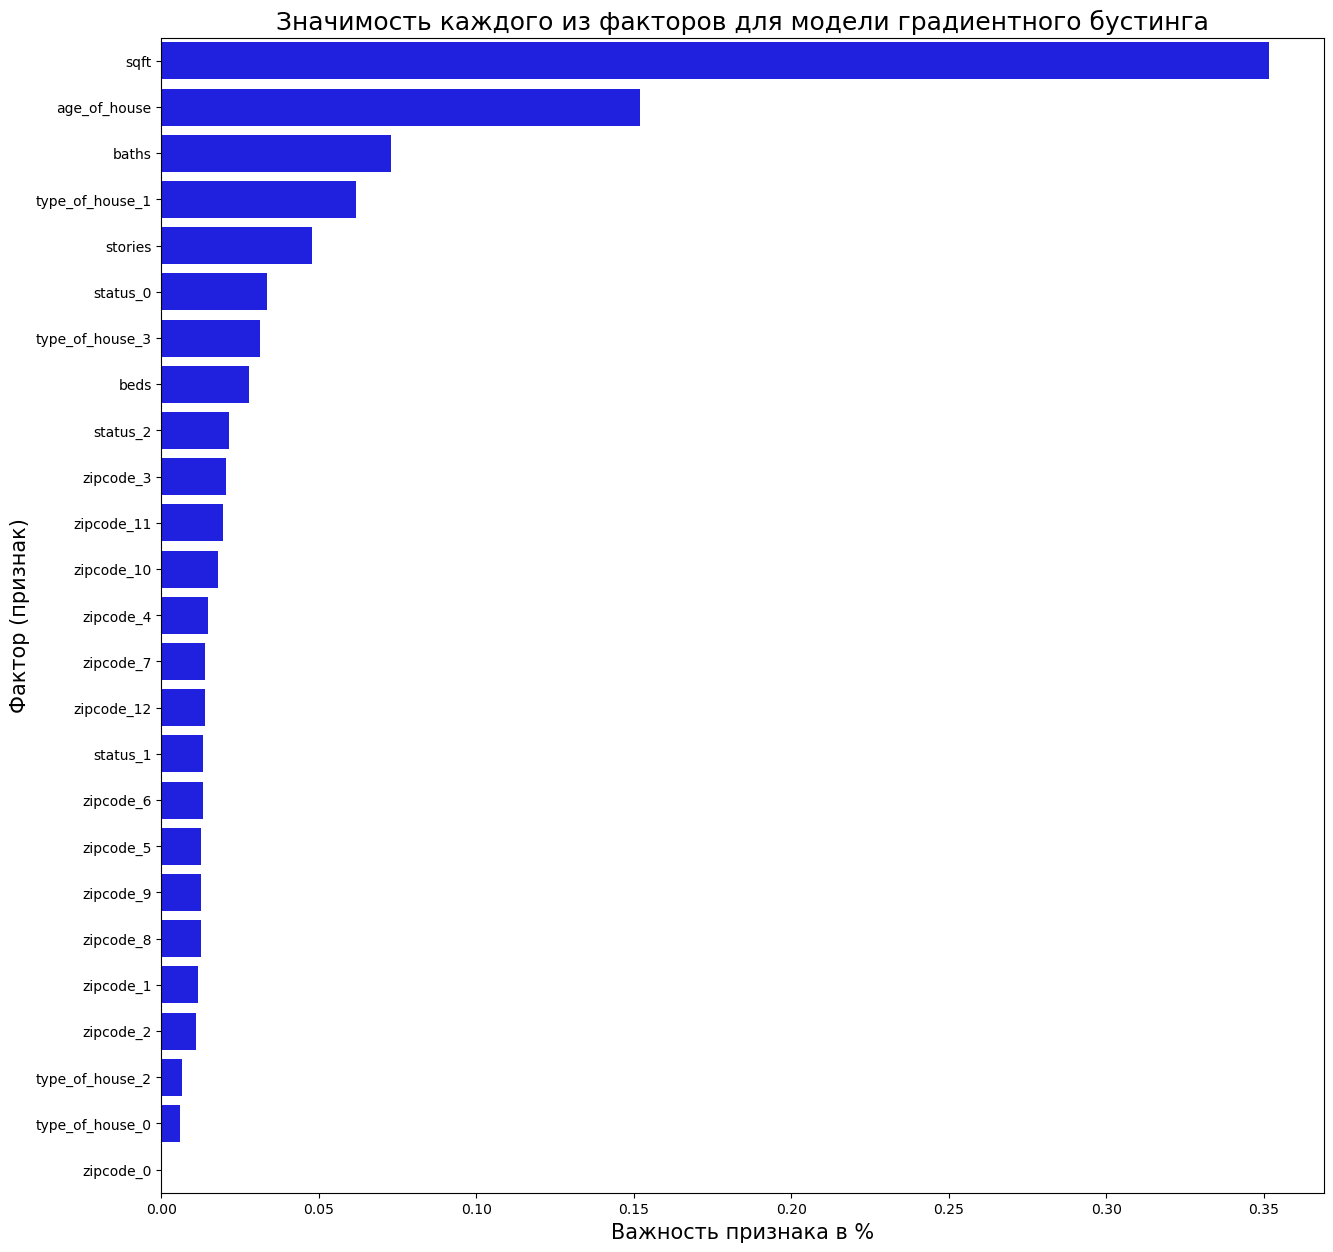

In [186]:
fig = plt.figure(figsize=(15, 15))
barplot = sns.barplot(
    data=feature_results,
    x='importance',
    y='feature',
    color='blue'
)
barplot.set_title('Значимость каждого из факторов для модели градиентного бустинга', fontsize=18)
barplot.set_xlabel('Важность признака в %', fontsize=15)
barplot.set_ylabel('Фактор (признак)', fontsize=15)
plt.show()

Посчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания цены жилья на валидационной выборке для лучшей из построенных моделей (градиентного бустинга):

In [187]:
# на всякий случай еще раз приводим данные к типу float
y_valid_log = y_valid_log.astype(np.float64)

In [188]:
y_valid =  np.exp(y_valid_log) - 1
y_valid_pr = np.exp(y_valid_pred) - 1

MeAE_valid_score =  metrics.median_absolute_error(y_valid, y_valid_pr)
print(round(MeAE_valid_score, 2)) 

85479.33


Получен не самый оптимальный результат (~86 тысяч долларов), который, видимо, объясняется в том числе и слишком большим разбросом в данных. Это также намекает на то, возможно, не вся информация из первичного датасета была использована для построения модели.

#### XGB бустинг

In [168]:
# Создаем список колонок - факторов датасета 
cols_data = data.columns

In [169]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=cols_data)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=cols_data)

In [170]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=500, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #ранняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:10.98530	valid-rmse:10.99188
[10]	train-rmse:3.89351	valid-rmse:3.89700
[20]	train-rmse:1.51107	valid-rmse:1.51134
[30]	train-rmse:0.83482	valid-rmse:0.83157
[40]	train-rmse:0.70076	valid-rmse:0.69645
[50]	train-rmse:0.67289	valid-rmse:0.66963
[60]	train-rmse:0.66246	valid-rmse:0.66059
[70]	train-rmse:0.65373	valid-rmse:0.65316
[80]	train-rmse:0.64798	valid-rmse:0.64905
[90]	train-rmse:0.64342	valid-rmse:0.64560
[100]	train-rmse:0.63867	valid-rmse:0.64223
[110]	train-rmse:0.63441	valid-rmse:0.63898
[120]	train-rmse:0.63178	valid-rmse:0.63736
[130]	train-rmse:0.62910	valid-rmse:0.63575
[140]	train-rmse:0.62491	valid-rmse:0.63257
[150]	train-rmse:0.62264	valid-rmse:0.63111
[160]	train-rmse:0.61720	valid-rmse:0.62701
[170]	train-rmse:0.61464	valid-rmse:0.62530
[180]	train-rmse:0.61199	valid-rmse:0.62352
[190]	train-rmse:0.60982	valid-rmse:0.62213
[200]	train-rmse:0.60719	valid-rmse:0.62022
[210]	train-rmse:0.60548	valid-rmse:0.61934
[220]	train-rmse:0.60367	valid-rmse:0.618

In [171]:
#Делаем предсказание на валидационном наборе данных
y_valid_predict = np.exp(model.predict(dvalid)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.58960


Модель на основе XGB бустинга показала результаты практически равные обычному градиентному бустингу.

**Вывод:** две наилучше модели - стандартный градиентный бустинг и XGB бустинг показали практически равные результаты. Для построения прогноза и воыовда в production останавливаемся на модели обычного градиентного бустинга.

# Построение прогноза

In [172]:
# Создаем список колонок - факторов датасета 
cols = data_baseline.drop(['target','target_log'],axis=1).columns

In [173]:
# Создаем запись - запрос на рпедсказание в формате факторов датасета
request_ = ['for reference', '3.5', 2900, '28387', 4, 1, 'single-family home',  4]

In [174]:
# Создаем функцию, принимающую исходную строку в формате data_baseline и возращающую предсказание в долларах
def final_predict(record):
    request_df = pd.DataFrame([record], columns=cols) # преобразуем полученный запрос в датафрейм
    request_enc = encoder.transform(request_df)       # кодируем датафрейм алгоритмами двоичного кодирования
    request_mm = scaler.transform(request_enc)        # нормализуем датафрейм посредством MinMaxScaler
    request_predict_log = gboost.predict(request_mm)  # делаем предсказание по модели градиентного бустинга
    return round(np.exp(request_predict_log[0]) - 1)

In [175]:
# Делаем предсказание для записи request_
final_predict(request_)

469514

# Подготовка модели к productions

In [176]:
# Создаём пайплайн, который включает все наши шаги по подготовке данных и обучению модели
pipe = Pipeline([  
  ('BinaryEncoder', encoder),
  ('MinMaxScaler', scaler),  
  ('GradientBoostingRegressor', gboost)
  ])
pipe

Pipeline(steps=[('BinaryEncoder',
                 BinaryEncoder(cols=['status', 'zipcode', 'type_of_house'],
                               mapping=[{'col': 'status',
                                         'mapping':     status_0  status_1  status_2
 1         0         0         1
 2         0         1         0
 3         0         1         1
 4         1         0         0
 5         1         0         1
 6         1         1         0
 7         1         1         1
-1         0         0         0
-2         0         0         0},
                                        {'col': 'zipcode',
                                         'mapping':        zipcode_0  zipcode_1  zipcode_2  zipcode_3  zipcode_4  zipcode_5  \
 1             0          0          0          0          0          0   
 2             0          0          0          0          0          0   
 3             0          0          0          0          0          0   
 4             0          0          0          0          0          0   
 5             0          0          0          0          0          0   
 6             0          0          0          0          0          0   
 7             0          0          0          0          0          0   
 8             0          0          0          0          0          0   
 9             0          0          0          0          0          0   
 10            0          0          0          0          0          0   
 11            0          0          0          0          0          0   
 1...
-1              0  
-2              0  },
                                        {'col': 'type_of_house',
                                         'mapping':      type_of_house_0  type_of_house_1  type_of_house_2  type_of_house_3
 1                 0                0                0                1
 2                 0                0                1                0
 3                 0                0                1                1
 4                 0                1                0                0
 5                 0                1                0                1
 6                 0                1                1                0
 7                 0                1                1                1
 8                 1                0                0                0
 9                 1                0                0                1
 10                1                0                1                0
 11                1                0                1                1
 12                1                1                0                0
 13                1                1                0                1
 14                1                1                1                0
-1                 0                0                0                0
-2                 0                0                0                0}])),
                ('MinMaxScaler', MinMaxScaler()),
                ('GradientBoostingRegressor',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=6,
                                           min_samples_split=30,
                                           random_state=42))])

In [177]:
data_baseline.head(10)

,status,baths,sqft,zipcode,beds,stories,target,target_log,type_of_house,age_of_house
0,for reference,3.5,2900.0,28387,4.0,1.0,418000.0,12.943239,single-family home,4
1,for reference,3.0,1947.0,99216,3.0,2.0,310000.0,12.644331,single-family home,4
2,for reference,2.0,3000.0,90049,3.0,1.0,2895000.0,14.878496,single-family home,62
5,for reference,3.0,897.0,19145,2.0,2.0,209000.0,12.250094,townhouse,103
8,for reference,2.0,3588.0,50401,3.0,1.0,244900.0,12.408609,single-family home,53
9,for reference,3.0,1930.0,77080,3.0,2.0,311995.0,12.650746,single-family home,4
10,for reference,2.0,1300.0,11354,3.0,6.0,669000.0,13.413541,coop,58
12,for reference,3.0,2839.0,33028,4.0,1.0,525000.0,13.171155,single-family home,27
13,for sale,2.0,1820.0,97401,3.0,1.0,499900.0,13.122165,single-family home,4
14,for reference,3.0,2454.0,77084,4.0,2.0,168800.0,12.036476,single-family home,41


In [178]:
# Преобразовываем данные для обучения пайплайна
X_pline = data_baseline.drop(['target', 'target_log'], axis=1)
y_pline = data_baseline['target_log']

In [179]:
# Обучаем пайплайн
pipe.fit(X_pline, y_pline)

Pipeline(steps=[('BinaryEncoder',
                 BinaryEncoder(cols=['status', 'zipcode', 'type_of_house'],
                               mapping=[{'col': 'status',
                                         'mapping':     status_0  status_1  status_2
 1         0         0         1
 2         0         1         0
 3         0         1         1
 4         1         0         0
 5         1         0         1
 6         1         1         0
 7         1         1         1
-1         0         0         0
-2         0         0         0},
                                        {'col': 'zipcode',
                                         'mapping':        zipcode_0  zipcode_1  zipcode_2  zipcode_3  zipcode_4  zipcode_5  \
 1             0          0          0          0          0          0   
 2             0          0          0          0          0          0   
 3             0          0          0          0          0          0   
 4             0          0          0          0          0          0   
 5             0          0          0          0          0          0   
 6             0          0          0          0          0          0   
 7             0          0          0          0          0          0   
 8             0          0          0          0          0          0   
 9             0          0          0          0          0          0   
 10            0          0          0          0          0          0   
 11            0          0          0          0          0          0   
 1...
-1              0  
-2              0  },
                                        {'col': 'type_of_house',
                                         'mapping':      type_of_house_0  type_of_house_1  type_of_house_2  type_of_house_3
 1                 0                0                0                1
 2                 0                0                1                0
 3                 0                0                1                1
 4                 0                1                0                0
 5                 0                1                0                1
 6                 0                1                1                0
 7                 0                1                1                1
 8                 1                0                0                0
 9                 1                0                0                1
 10                1                0                1                0
 11                1                0                1                1
 12                1                1                0                0
 13                1                1                0                1
 14                1                1                1                0
-1                 0                0                0                0
-2                 0                0                0                0}])),
                ('MinMaxScaler', MinMaxScaler()),
                ('GradientBoostingRegressor',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=6,
                                           min_samples_split=30,
                                           random_state=42))])

In [180]:
# Сериализуем модель и записываем результат в файл
with open('fpro_pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

In [181]:
# Десериализуем pipeline из файла
with open('fpro_pipeline.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)

In [182]:
# Делаем предсказание (выберем статус 'for rent' - цена должна быть значительно ниже)
request_ = ['for rent', '3', 3000, '11354', 3, 1, 'coop',  40]
req_fin = pd.DataFrame([request_], columns=cols)
log_pred = loaded_pipe.predict(req_fin)

In [183]:
# Переводим из логарифмического представления в первоначальное представление столбца target
round(np.exp(log_pred[0])-1)

23262

### Воспроизводимость и контейнеризация

Создадим и зафиксируем файл requirements.txt : **pip freeze > requirements.txt**

### Контейнеризация Docker

Базовый образ, который буду использовать для своего контейнера — **tiangolo/uwsgi-nginx-flask**

Этот образ этот создан на базе ОС Linux с настроенными в нем взаимодействия серверов uWSGI и NGINX через сокеты.

Вся необходимая структура и сам конфигурационный файл для создания Docker образа находится в директории fin_project.

Строим образ в терминале проекта командой: **docker build -t fin_project .**

Запускаем собранный контейнер командой **docker run** на 80 порту: **docker run -it --rm --name=fin_project -p=80:80 fin_project**

После этого можно выполнить POST-запрос, запустив в соседнем терминале скрипт для отправки запросов на 'http://localhost/predict'. В скрипте прописаны параметры гипотетического нового объекта недвижимости (использовались те же данные, что и при предсказании в пайплайне в предыдущем разделе).

**python3 test/client.py**

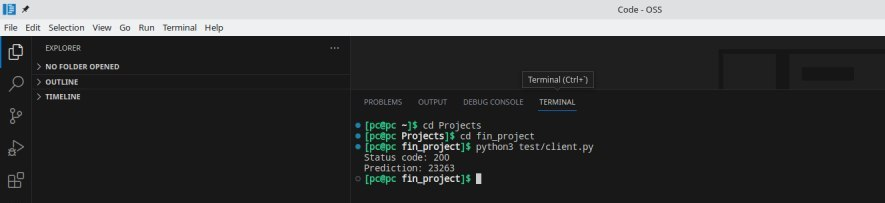

Меняя в строке запроса в файле client.py параметры предполагаемого объекта можно получить новое предсказание на новый запрос.

# Заключение

В рамках построения оптимальной модели проведен разведывательный анализ EDA, построены рабочие модели, среди последних выбрана наилучшая (градиентный бустинг), создан pipeline и реализован процесс контейнеризации модели и вывода в production.